In [ ]:
import pandas as pd
import os

data_dirs = {
    'anomaly_free': 'anomaly-free',
    'valve1': 'valve1',
    'valve2': 'valve2'
}

def load_csv_files_from_dir(directory_path, include_filename=False):
    df_list = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory_path, filename)
            df = pd.read_csv(file_path, sep=';', decimal='.', parse_dates=['datetime'])
            if include_filename:
                df['source_file'] = filename
            df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

anomaly_free_df = load_csv_files_from_dir('anomaly-free')
valve1_df = load_csv_files_from_dir('valve1', include_filename=True)
valve2_df = load_csv_files_from_dir('valve2', include_filename=True)

print("Anomaly-Free Data:")
print(anomaly_free_df.info())
print("\nValve1 Data:")
print(valve1_df.info())
print("\nValve2 Data:")
print(valve2_df.info())

print("\nAnomaly-Free Data Description:")
print(anomaly_free_df.describe())

print("\nValve1 Data Description:")
print(valve1_df.describe())

print("\nValve2 Data Description:")
print(valve2_df.describe())

print("\nMissing values in Anomaly-Free Data:")
print(anomaly_free_df.isnull().sum())

print("\nMissing values in Valve1 Data:")
print(valve1_df.isnull().sum())

print("\nMissing values in Valve2 Data:")
print(valve2_df.isnull().sum())


Anomaly-Free Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9405 entries, 0 to 9404
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             9405 non-null   datetime64[ns]
 1   Accelerometer1RMS    9405 non-null   float64       
 2   Accelerometer2RMS    9405 non-null   float64       
 3   Current              9405 non-null   float64       
 4   Pressure             9405 non-null   float64       
 5   Temperature          9405 non-null   float64       
 6   Thermocouple         9405 non-null   float64       
 7   Voltage              9405 non-null   float64       
 8   Volume Flow RateRMS  9405 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 661.4 KB
None

Valve1 Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18160 entries, 0 to 18159
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
--

Feature Distributions for Anomaly-Free Data


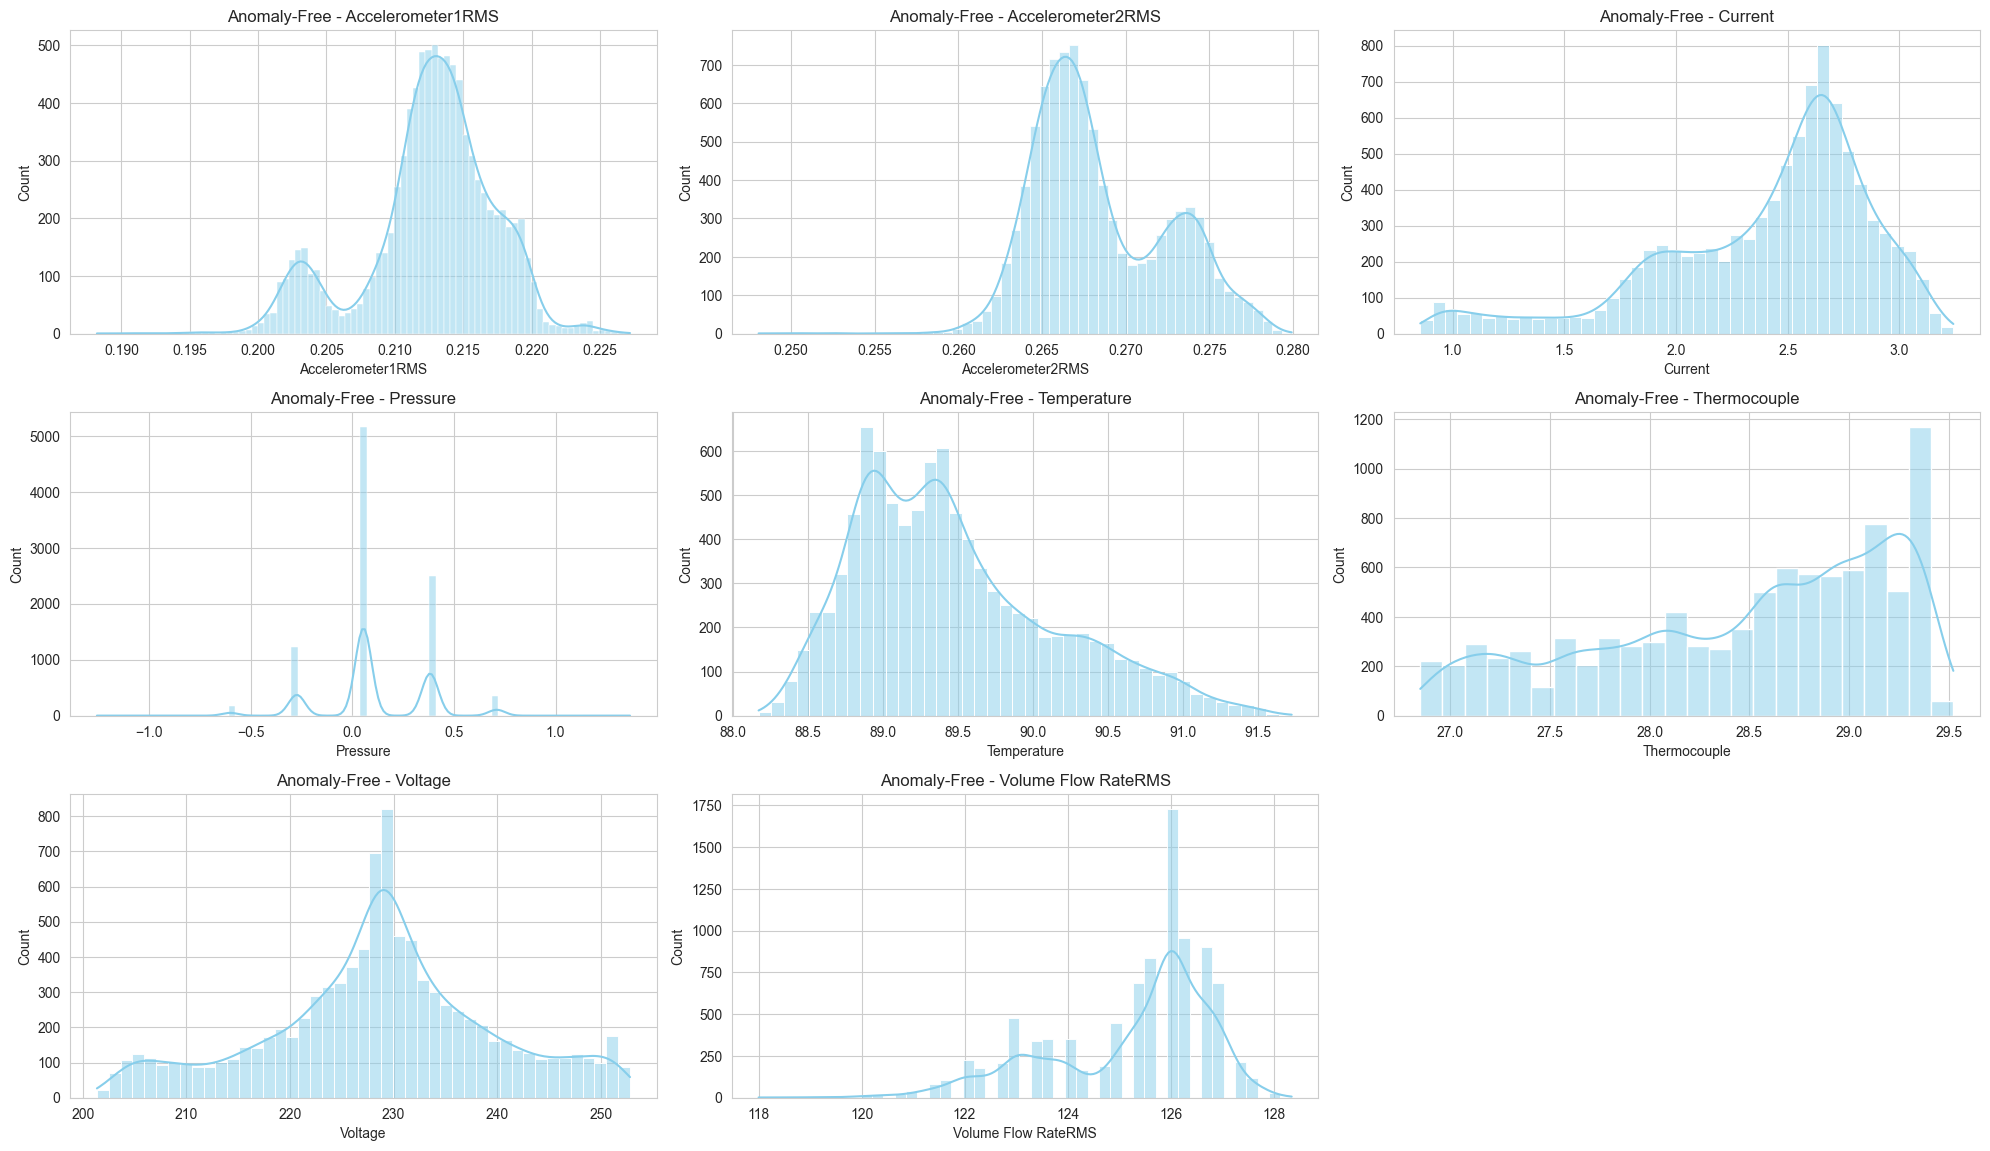

Feature Distributions for Valve1 Data


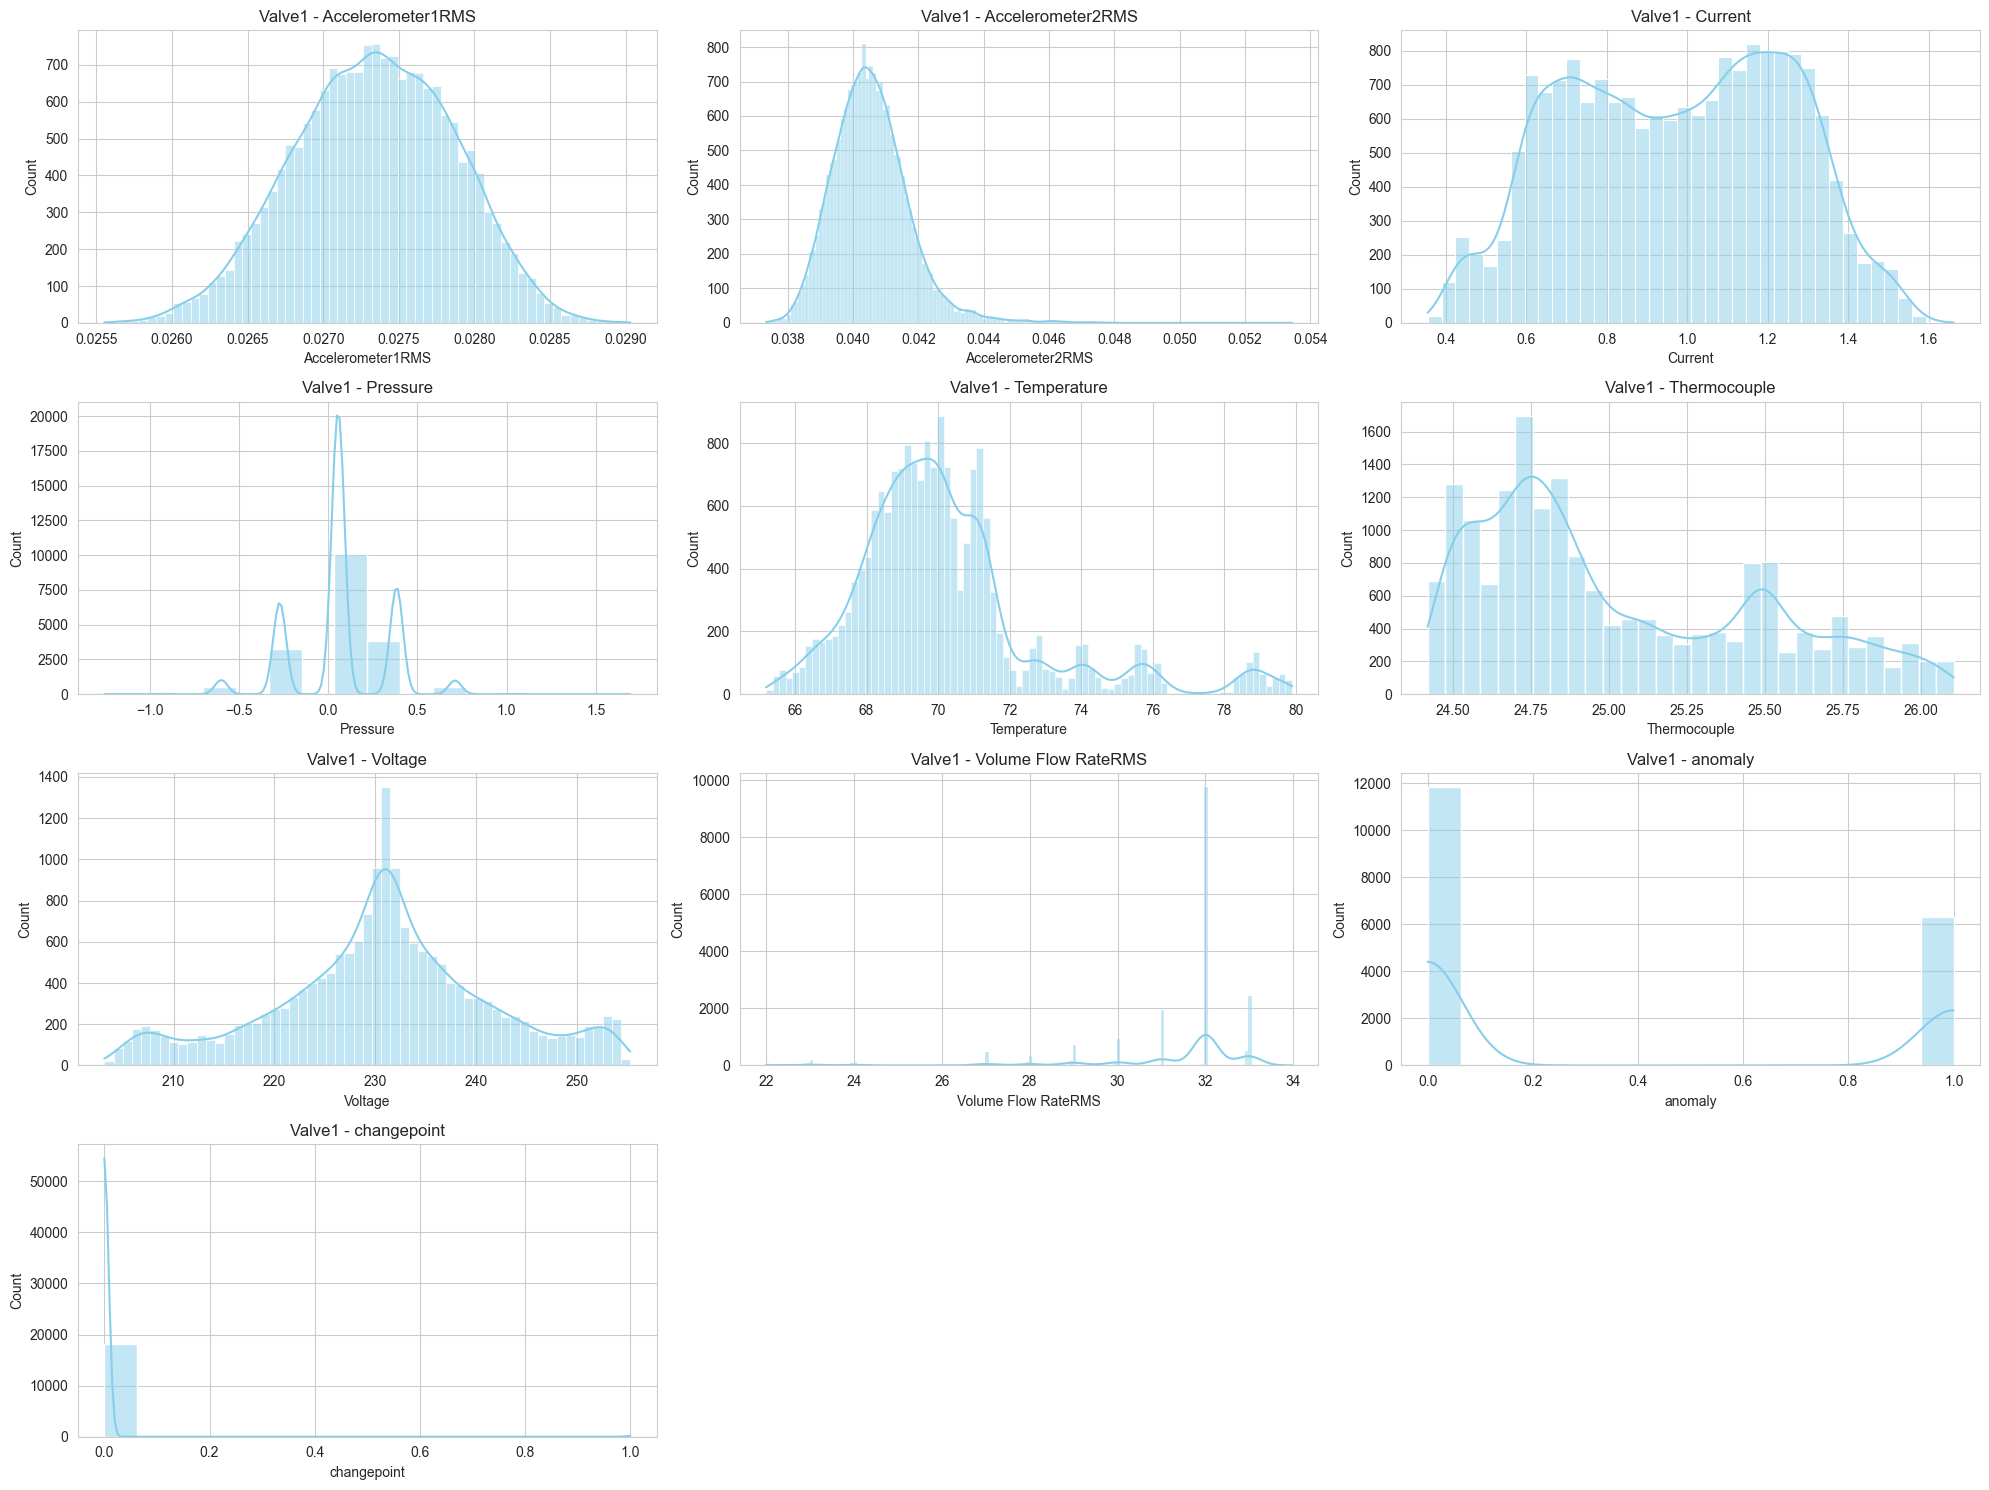

Feature Distributions for Valve2 Data


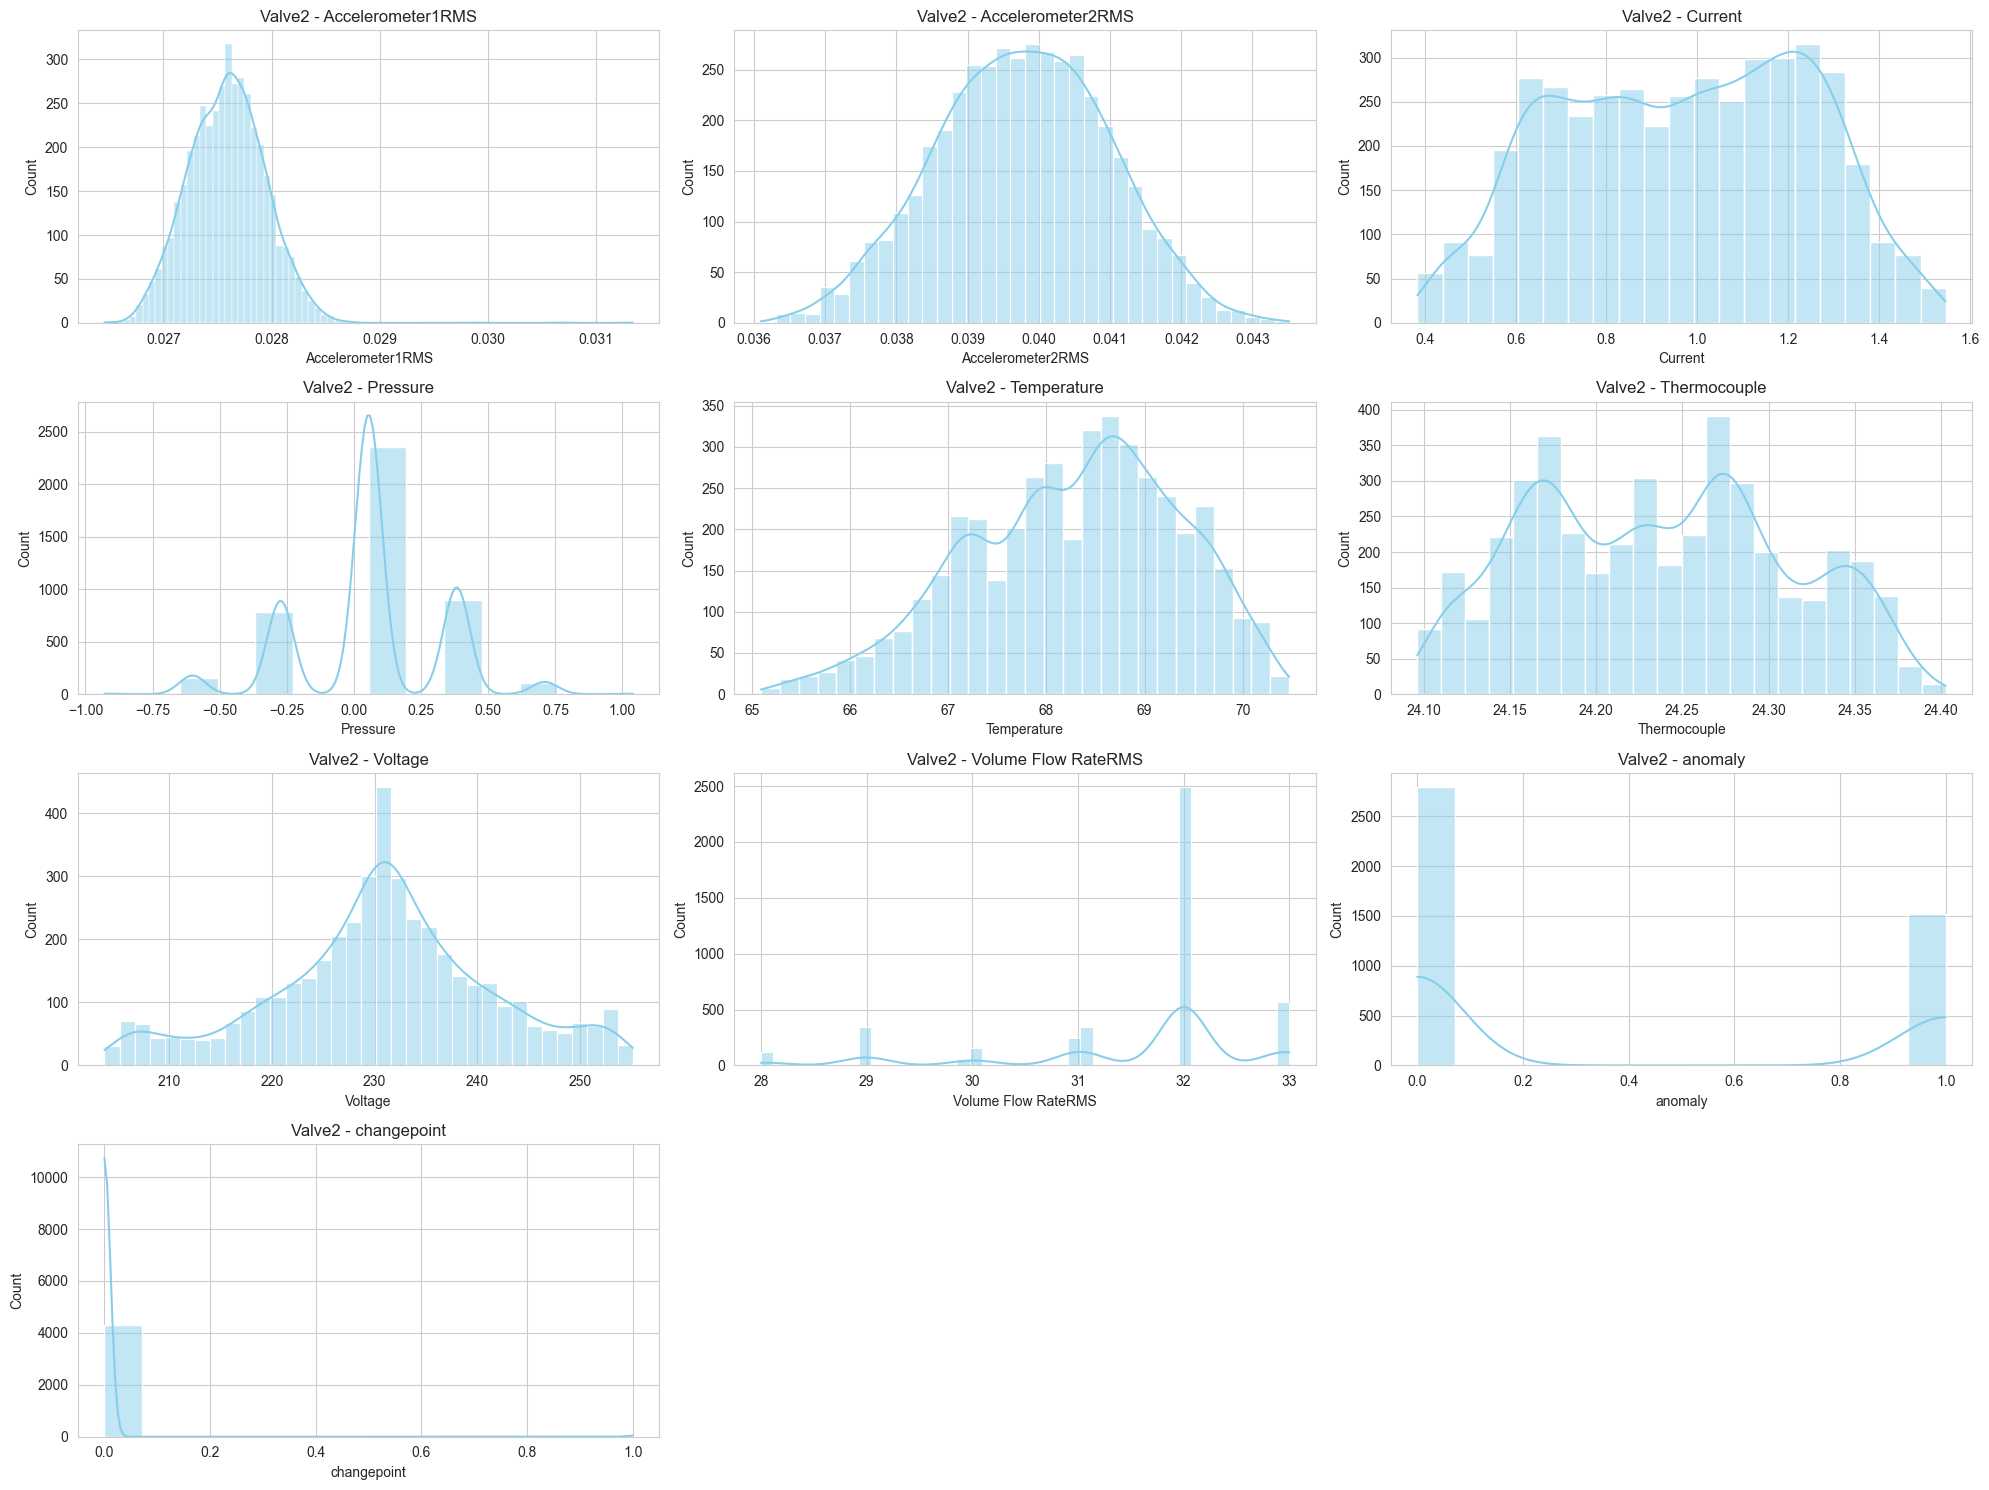

Correlation Heatmap for Anomaly-Free Data


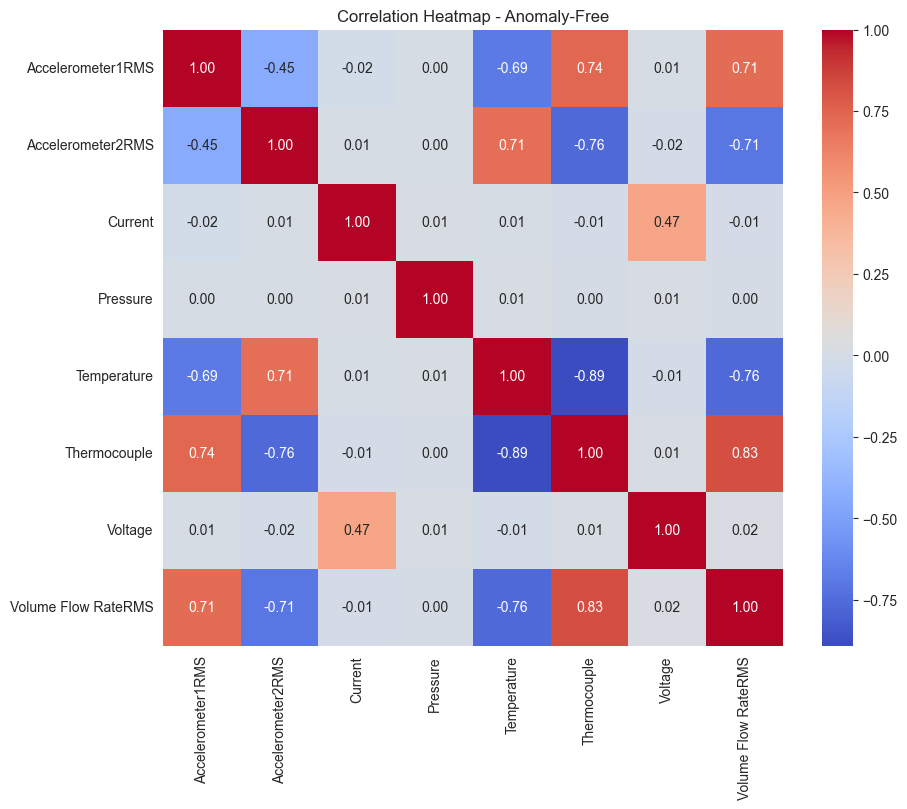

Correlation Heatmap for Valve1 Data


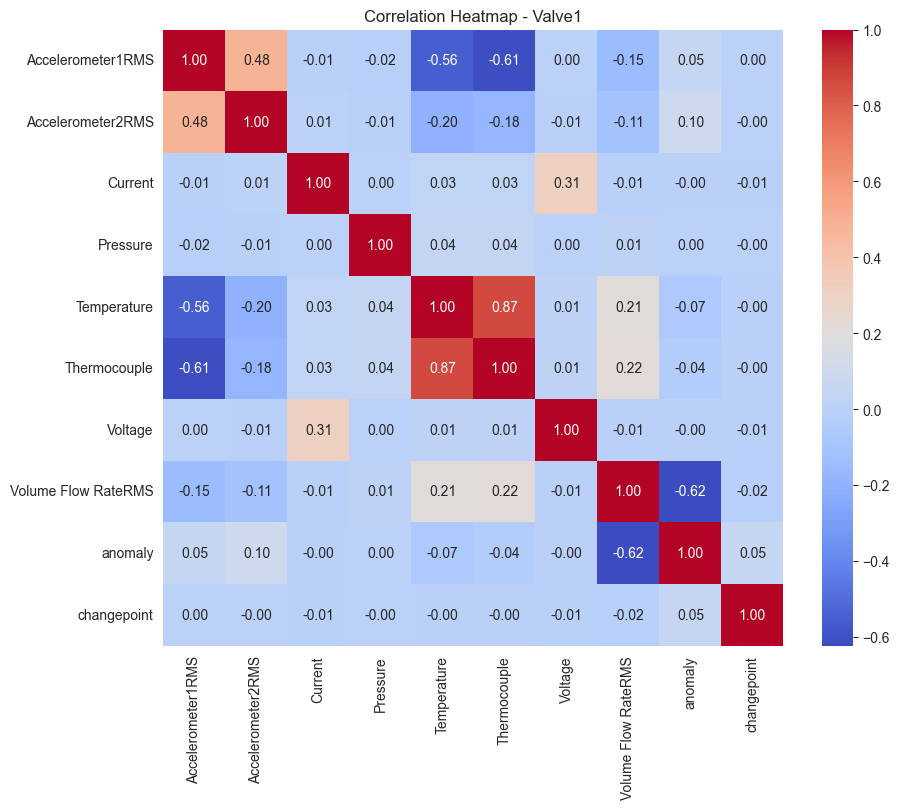

Correlation Heatmap for Valve2 Data


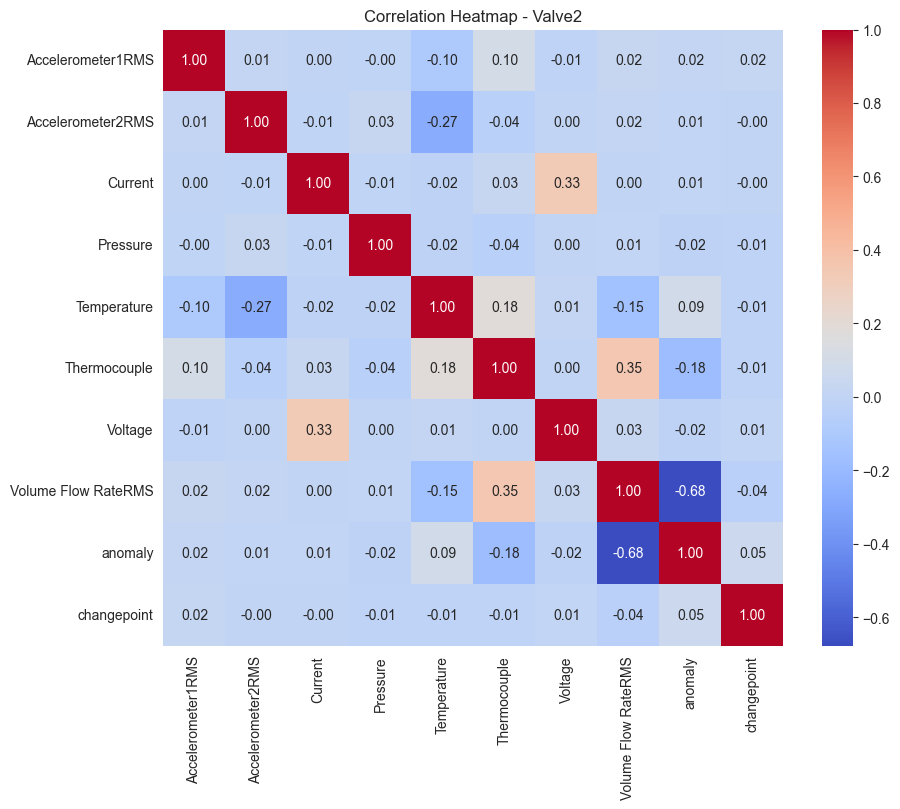

Time Series for Anomaly-Free Data


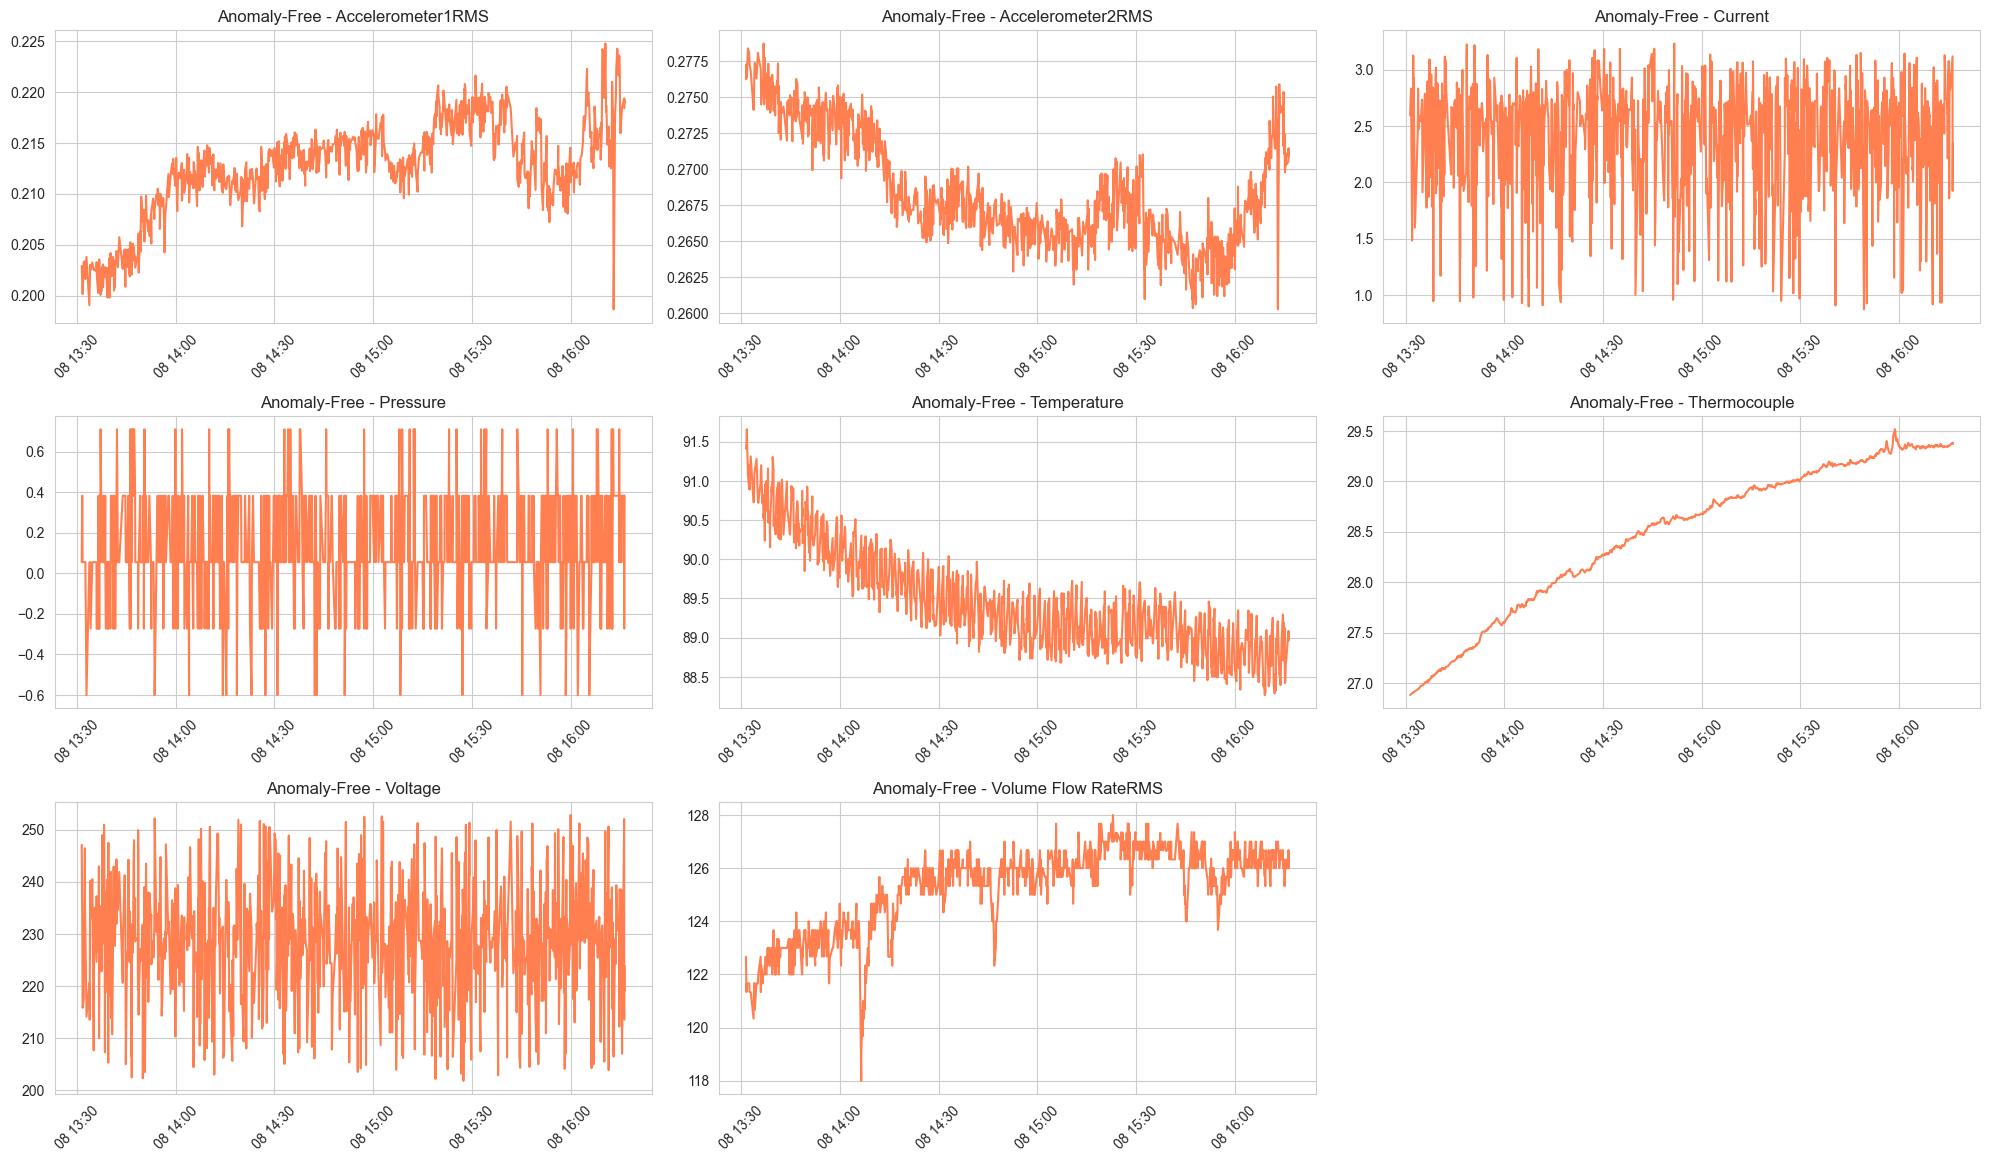

Time Series for Valve1 Data


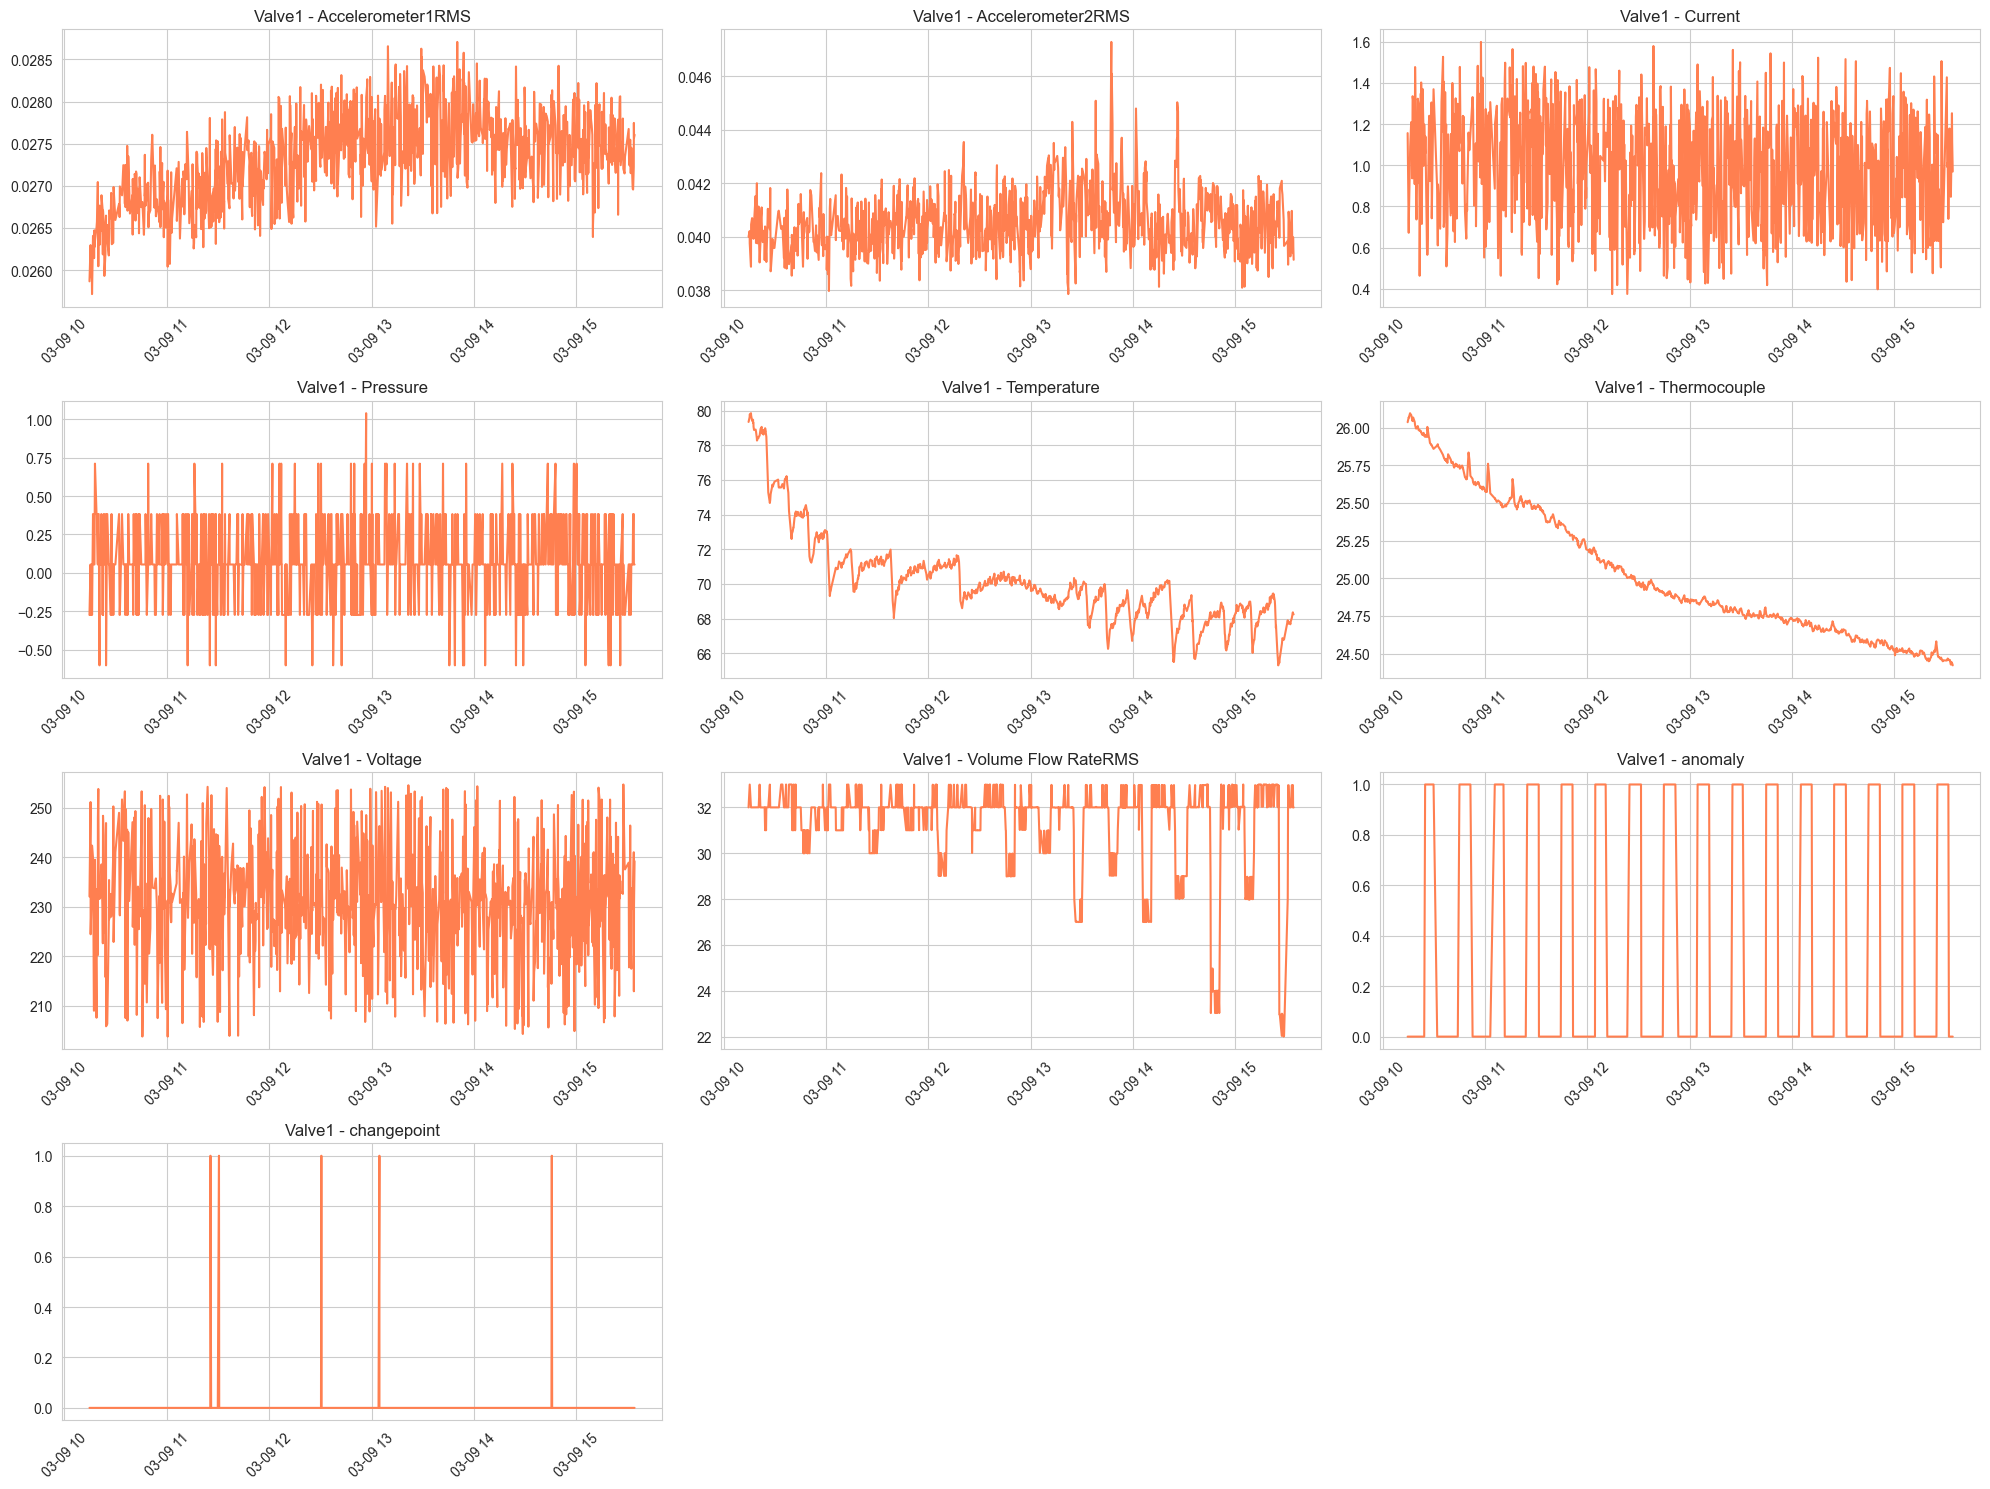

Time Series for Valve2 Data


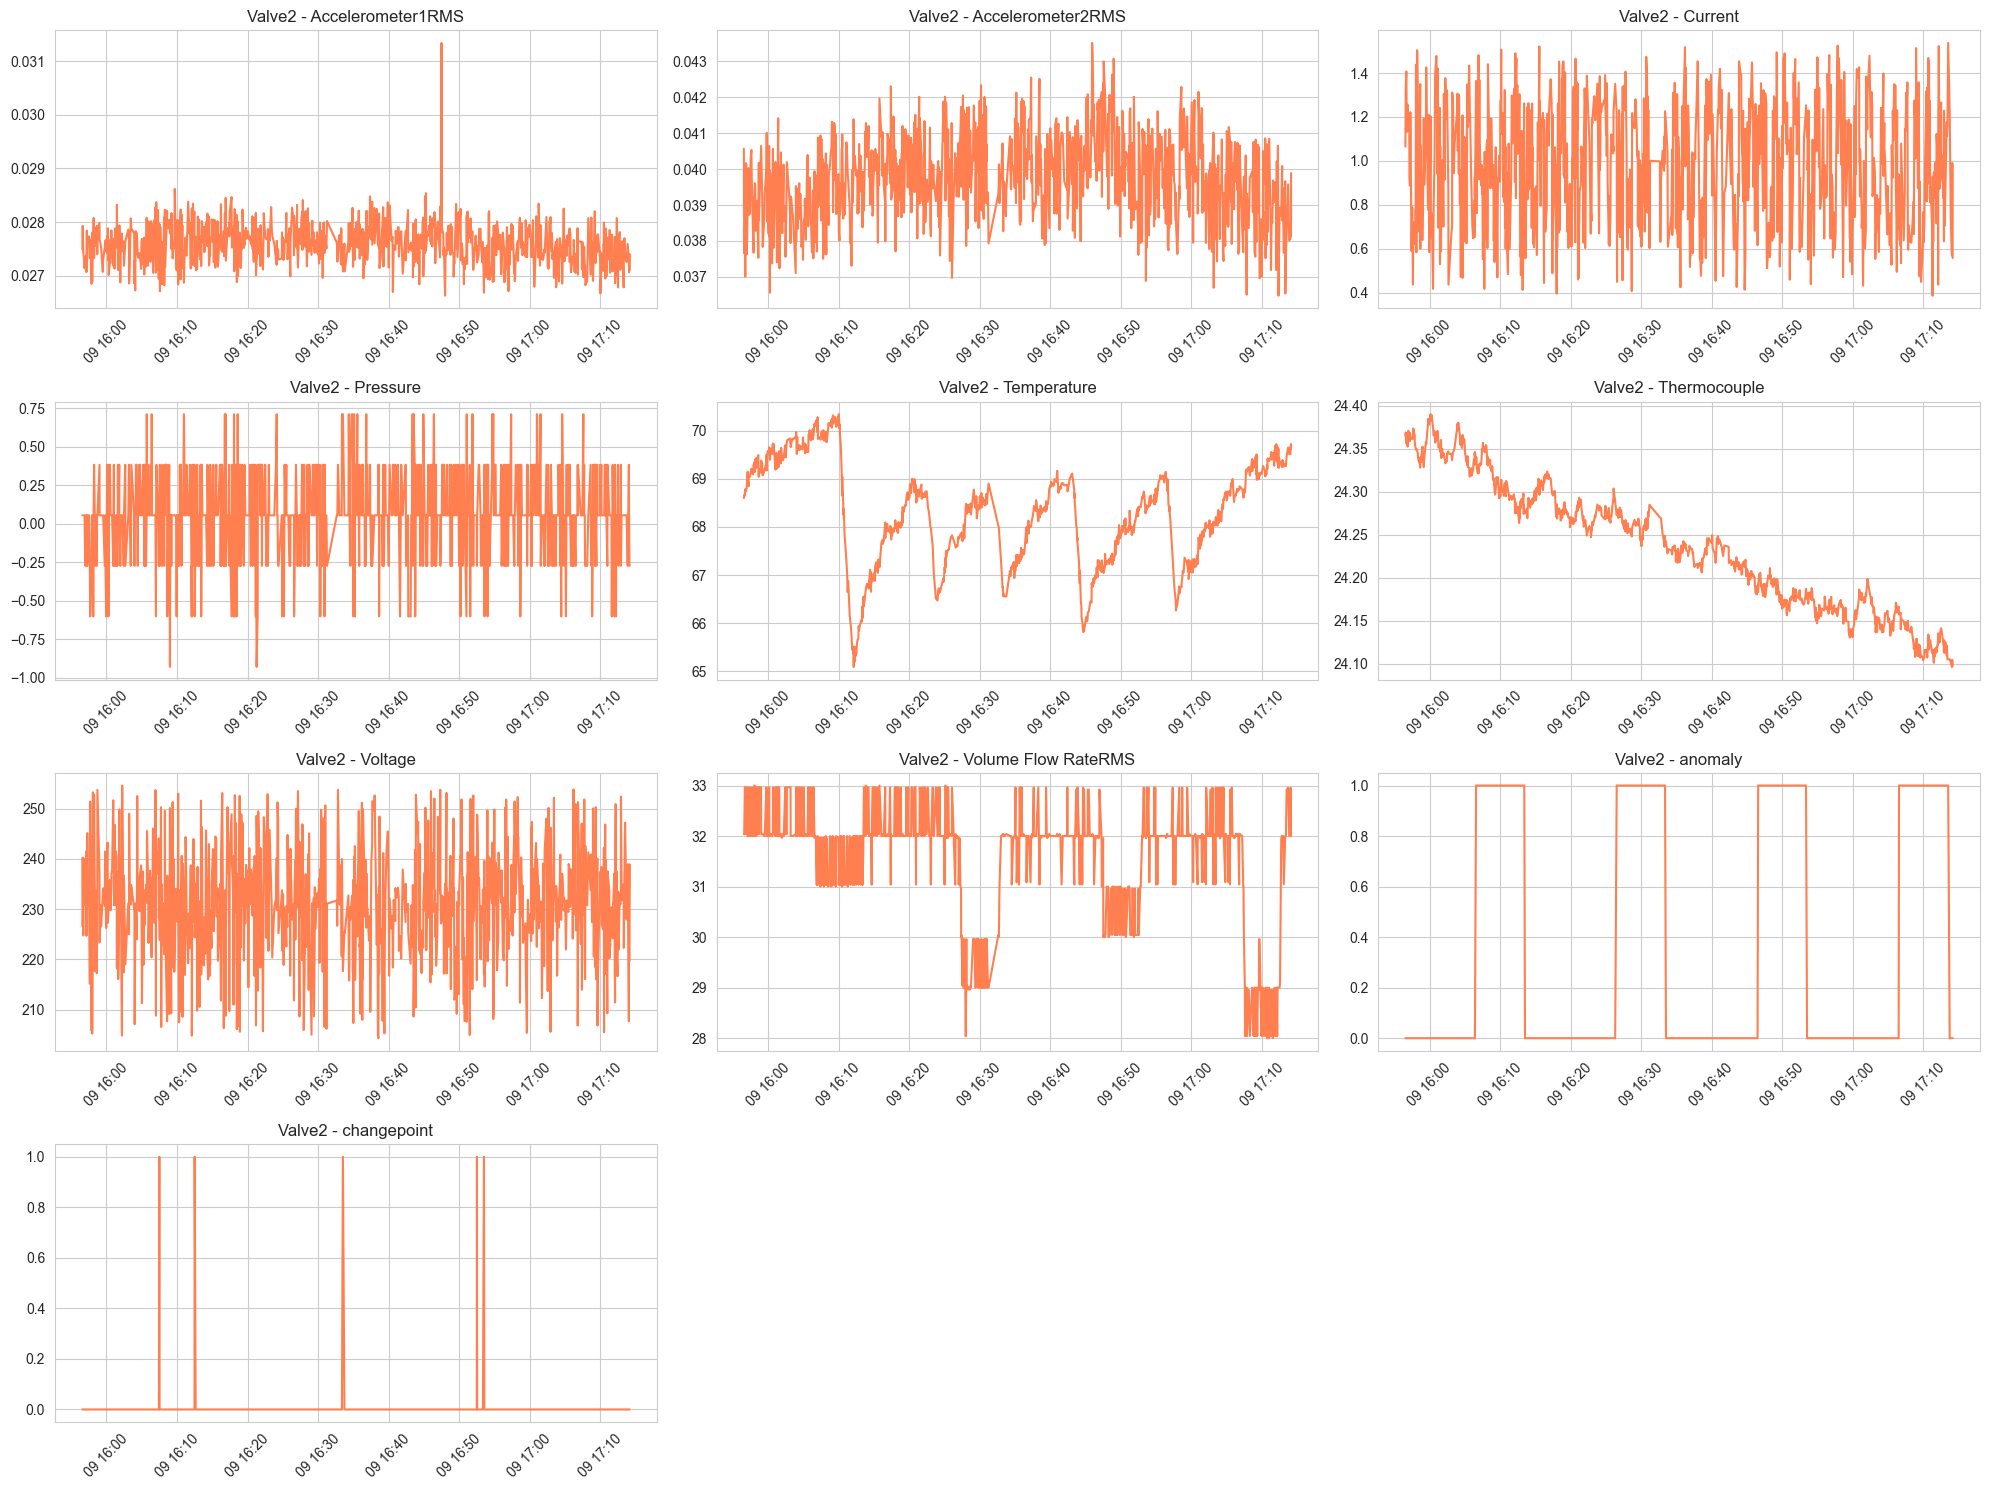

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
sns.set_style("whitegrid")

def plot_feature_distributions(df, dataset_name):
    numeric_columns = df.select_dtypes(include=['float64']).columns
    plt.figure(figsize=(20, 15))
    for i, column in enumerate(numeric_columns, 1):
        plt.subplot(4, 3, i)
        sns.histplot(df[column], kde=True, color='skyblue')
        plt.title(f'{dataset_name} - {column}')
    plt.tight_layout()
    plt.show()

print("Feature Distributions for Anomaly-Free Data")
plot_feature_distributions(anomaly_free_df, "Anomaly-Free")

print("Feature Distributions for Valve1 Data")
plot_feature_distributions(valve1_df, "Valve1")

print("Feature Distributions for Valve2 Data")
plot_feature_distributions(valve2_df, "Valve2")

def plot_correlation_heatmap(df, dataset_name):
    numeric_columns = df.select_dtypes(include=['float64'])
    plt.figure(figsize=(10, 8))
    correlation_matrix = numeric_columns.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f'Correlation Heatmap - {dataset_name}')
    plt.show()

print("Correlation Heatmap for Anomaly-Free Data")
plot_correlation_heatmap(anomaly_free_df, "Anomaly-Free")

print("Correlation Heatmap for Valve1 Data")
plot_correlation_heatmap(valve1_df, "Valve1")

print("Correlation Heatmap for Valve2 Data")
plot_correlation_heatmap(valve2_df, "Valve2")

def plot_time_series(df, dataset_name, max_points=1000):
    """Plot time series for each feature"""
    numeric_columns = df.select_dtypes(include=['float64']).columns
    sample_df = df.sample(n=min(max_points, len(df))).sort_values('datetime')
    plt.figure(figsize=(20, 15))
    for i, column in enumerate(numeric_columns, 1):
        plt.subplot(4, 3, i)
        plt.plot(sample_df['datetime'], sample_df[column], color='coral')
        plt.title(f'{dataset_name} - {column}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("Time Series for Anomaly-Free Data")
plot_time_series(anomaly_free_df, "Anomaly-Free")

print("Time Series for Valve1 Data")
plot_time_series(valve1_df, "Valve1")

print("Time Series for Valve2 Data")
plot_time_series(valve2_df, "Valve2")


## LoF

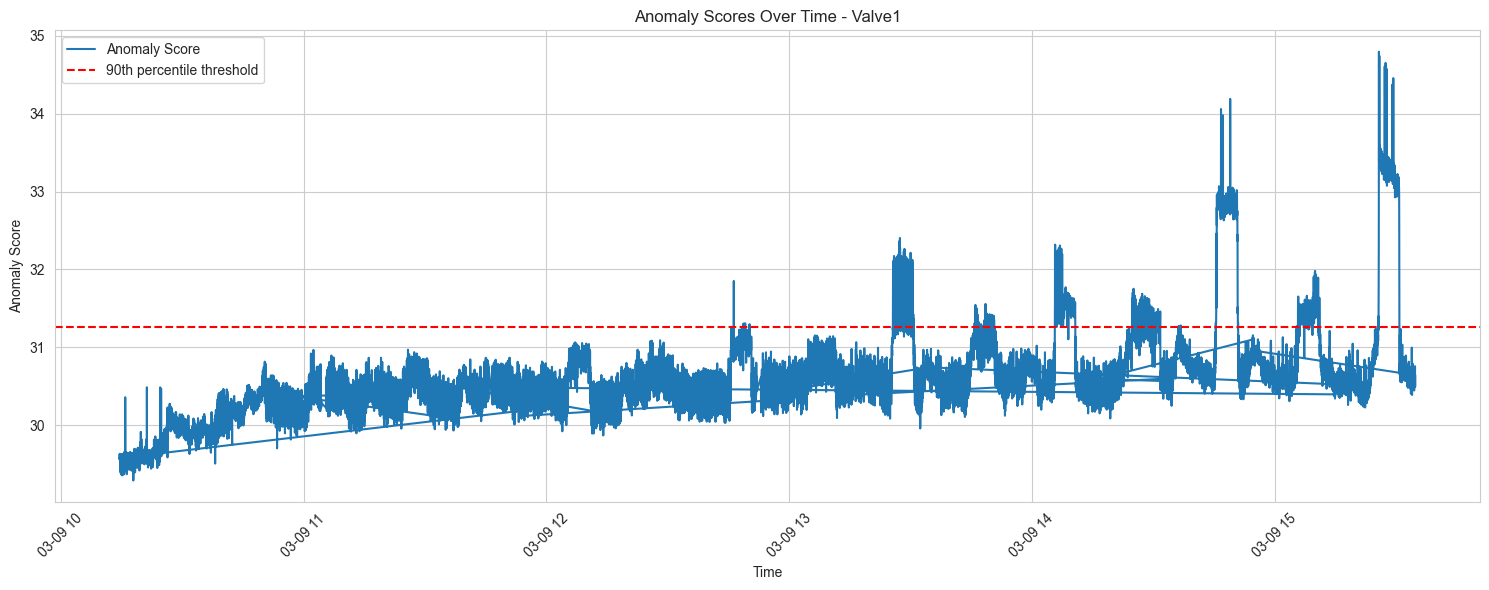

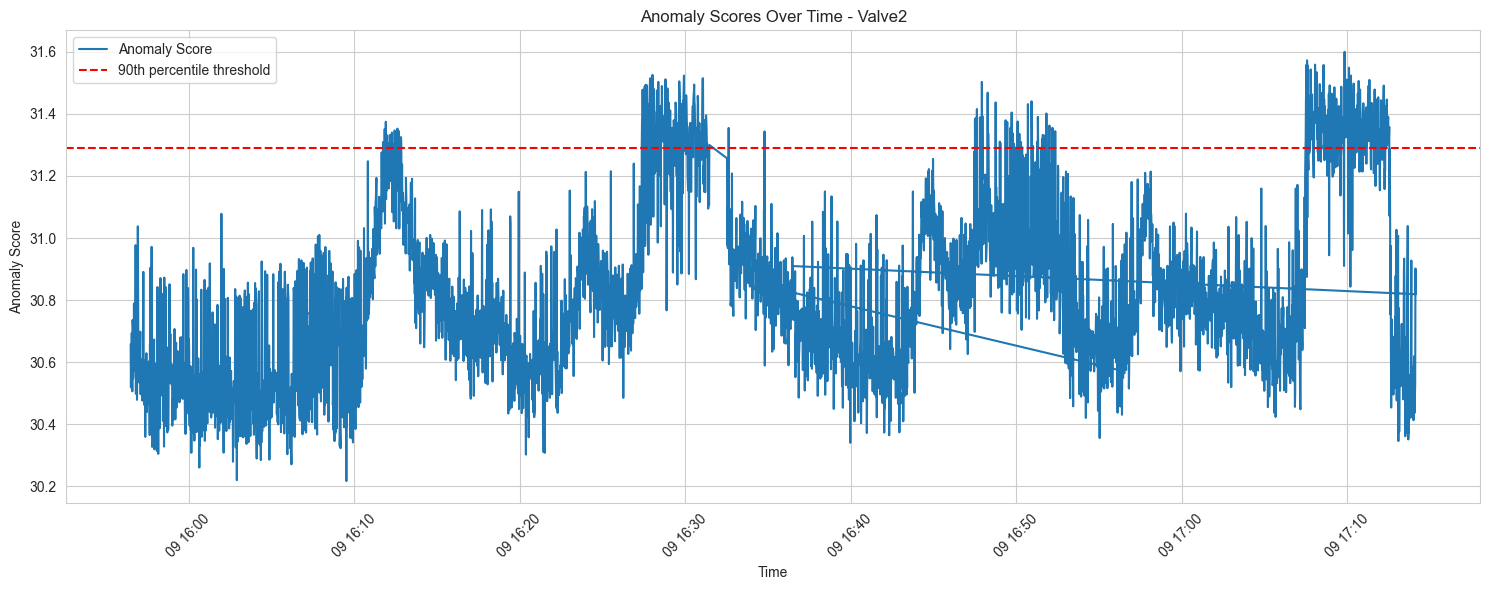

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

def prepare_data_for_lof(anomaly_free_df, valve1_df, valve2_df):
    numeric_columns = [
        "Accelerometer1RMS", "Accelerometer2RMS", "Current", "Pressure",
        "Temperature", "Thermocouple", "Voltage", "Volume Flow RateRMS"
    ]
    
    scaler = StandardScaler()
    scaler.fit(anomaly_free_df[numeric_columns])
    
    anomaly_free_scaled = scaler.transform(anomaly_free_df[numeric_columns])
    valve1_scaled = scaler.transform(valve1_df[numeric_columns])
    valve2_scaled = scaler.transform(valve2_df[numeric_columns])
    
    return anomaly_free_scaled, valve1_scaled, valve2_scaled, scaler

def detect_anomalies(anomaly_free_scaled, test_scaled, n_neighbors=20, contamination=0.1):
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, 
                            novelty=True,
                            contamination=contamination)
    lof.fit(anomaly_free_scaled)
    
    predictions = lof.predict(test_scaled)
    anomaly_scores = -lof.score_samples(test_scaled)
    
    return predictions, anomaly_scores

anomaly_free_scaled, valve1_scaled, valve2_scaled, scaler = prepare_data_for_lof(
    anomaly_free_df, valve1_df, valve2_df
)

valve1_predictions, valve1_scores = detect_anomalies(anomaly_free_scaled, valve1_scaled)

valve2_predictions, valve2_scores = detect_anomalies(anomaly_free_scaled, valve2_scaled)

def plot_anomaly_scores(df, scores, dataset_name):
    plt.figure(figsize=(15, 6))
    plt.plot(df['datetime'], scores, label='Anomaly Score')
    plt.axhline(y=np.percentile(scores, 90), color='r', linestyle='--', 
                label='90th percentile threshold')
    plt.title(f'Anomaly Scores Over Time - {dataset_name}')
    plt.xlabel('Time')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_anomaly_scores(valve1_df, valve1_scores, 'Valve1')
plot_anomaly_scores(valve2_df, valve2_scores, 'Valve2')


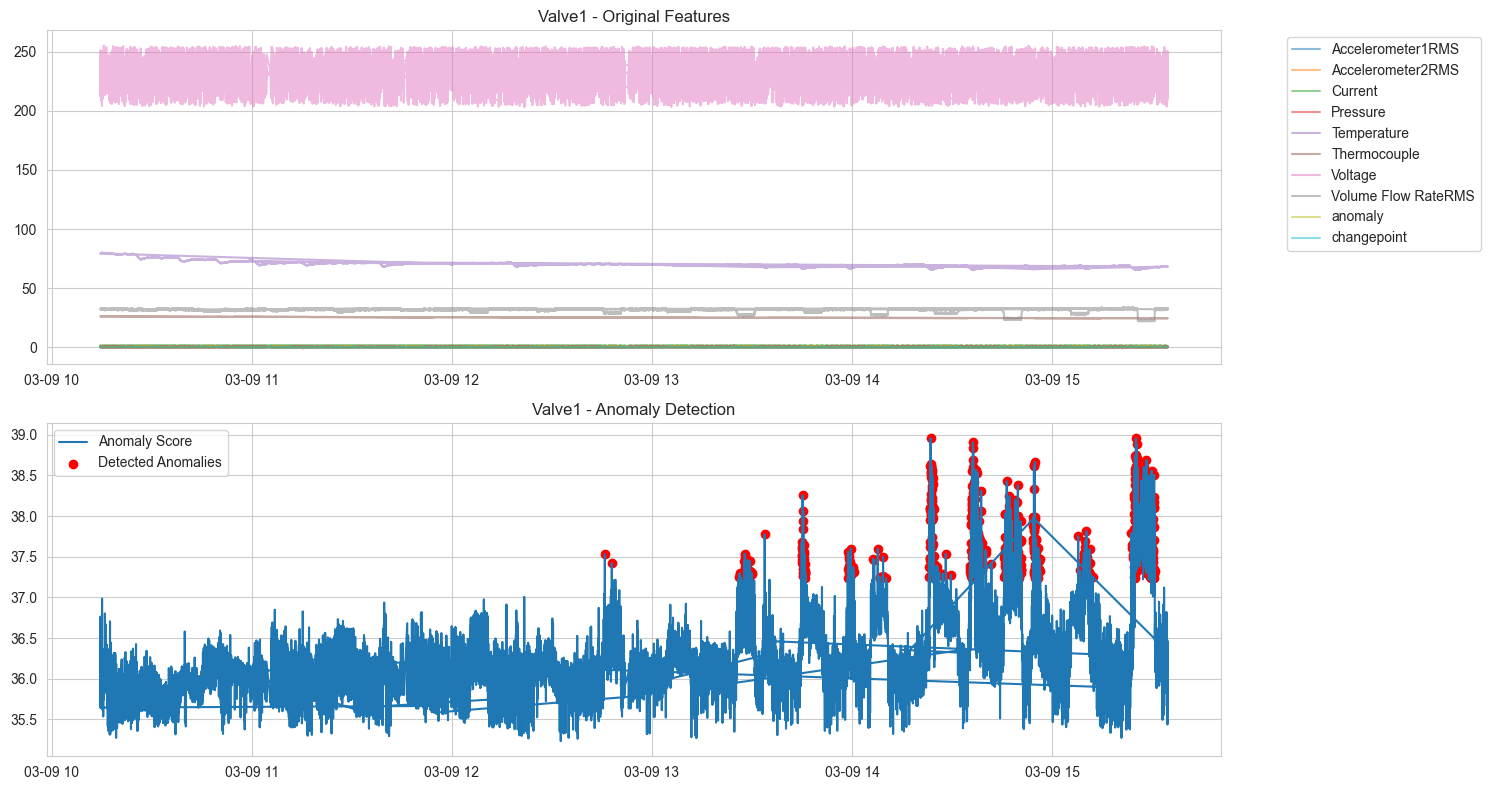

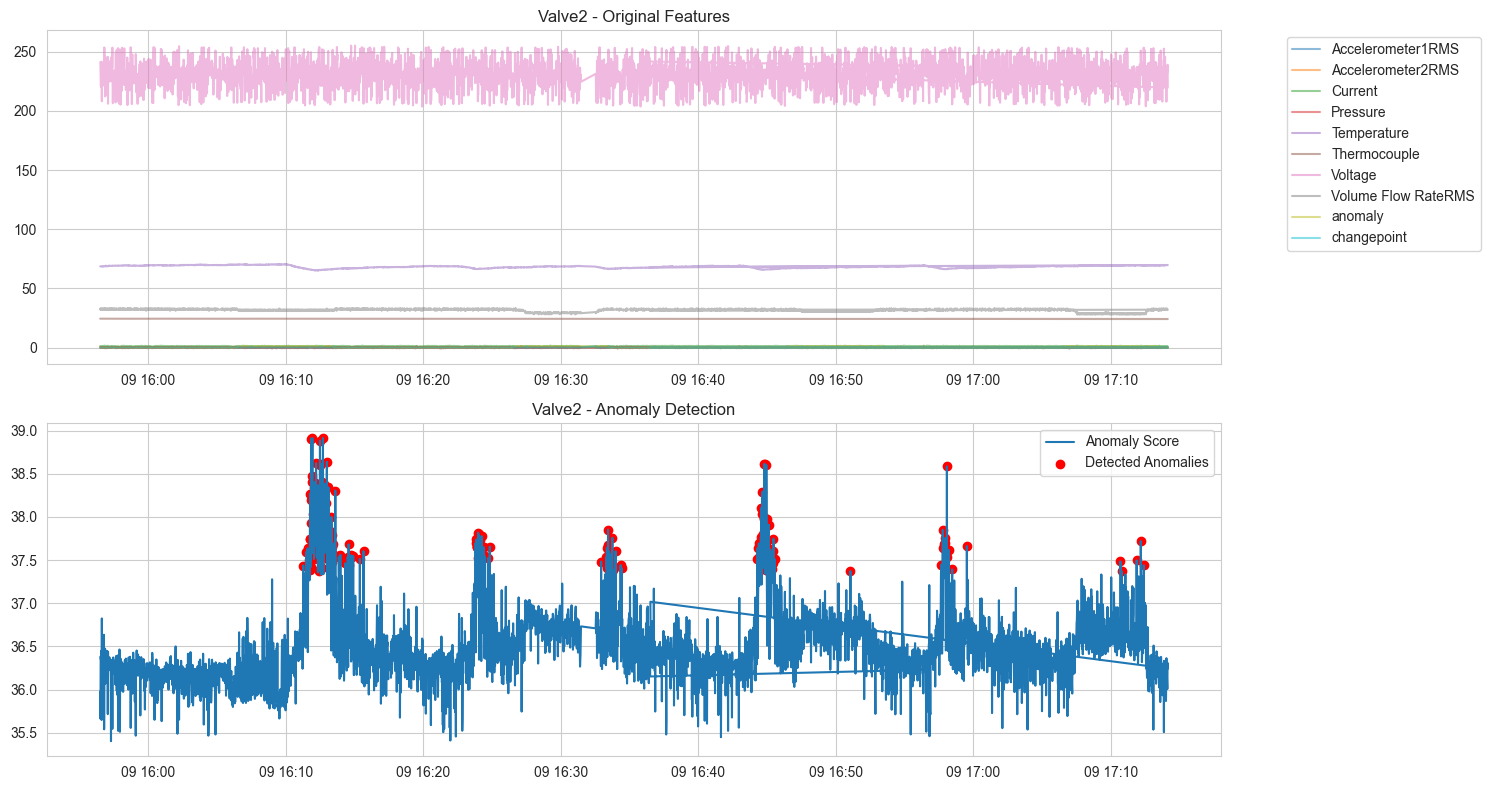

Valve1 anomaly rate: 0.046
Valve2 anomaly rate: 0.046


In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

def prepare_data_for_lof(anomaly_free_df, valve1_df, valve2_df):
    numeric_columns = [
        "Accelerometer1RMS", "Accelerometer2RMS", "Current", "Pressure",
        "Temperature", "Thermocouple", "Voltage", "Volume Flow RateRMS"
    ]
    
    scaler = RobustScaler()
    scaler.fit(anomaly_free_df[numeric_columns])
    
    anomaly_free_scaled = scaler.transform(anomaly_free_df[numeric_columns])
    valve1_scaled = scaler.transform(valve1_df[numeric_columns])
    valve2_scaled = scaler.transform(valve2_df[numeric_columns])
    
    return anomaly_free_scaled, valve1_scaled, valve2_scaled, scaler

def detect_anomalies(anomaly_free_scaled, test_scaled):
    lof = LocalOutlierFactor(
        n_neighbors=50,  
        novelty=True,
        contamination=0.005,  
        metric='euclidean'
    )
    lof.fit(anomaly_free_scaled)
    
    scores = -lof.score_samples(test_scaled)
    
    threshold = np.mean(scores) + 2 * np.std(scores)
    predictions = (scores > threshold).astype(int)
    
    return predictions, scores

def plot_results(df, scores, predictions, title):
    plt.figure(figsize=(15, 8))
    
    plt.subplot(211)
    for col in df.select_dtypes(include=['float64']).columns:
        plt.plot(df['datetime'], df[col], alpha=0.5, label=col)
    plt.title(f'{title} - Original Features')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(212)
    plt.plot(df['datetime'], scores, label='Anomaly Score')
    plt.scatter(df['datetime'][predictions == 1], 
               scores[predictions == 1], 
               color='red', 
               label='Detected Anomalies')
    plt.title(f'{title} - Anomaly Detection')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

anomaly_free_scaled, valve1_scaled, valve2_scaled, scaler = prepare_data_for_lof(
    anomaly_free_df, valve1_df, valve2_df
)

valve1_predictions, valve1_scores = detect_anomalies(anomaly_free_scaled, valve1_scaled)
valve2_predictions, valve2_scores = detect_anomalies(anomaly_free_scaled, valve2_scaled)

plot_results(valve1_df, valve1_scores, valve1_predictions, 'Valve1')
plot_results(valve2_df, valve2_scores, valve2_predictions, 'Valve2')

print(f"Valve1 anomaly rate: {np.mean(valve1_predictions):.3f}")
print(f"Valve2 anomaly rate: {np.mean(valve2_predictions):.3f}")

In [ ]:
def calculate_metrics(predictions, scores):
    threshold = np.percentile(scores, 95)
    assumed_truth = (scores > threshold).astype(int)
    
    precision = precision_score(assumed_truth, predictions)
    recall = recall_score(assumed_truth, predictions)
    f1 = f1_score(assumed_truth, predictions)
    
    return precision, recall, f1

precision_v1, recall_v1, f1_v1 = calculate_metrics(valve1_predictions, valve1_scores)
print("\nValve1 Metrics:")
print(f"Precision: {precision_v1:.3f}")
print(f"Recall: {recall_v1:.3f}")
print(f"F1-score: {f1_v1:.3f}")

precision_v2, recall_v2, f1_v2 = calculate_metrics(valve2_predictions, valve2_scores)
print("\nValve2 Metrics:")
print(f"Precision: {precision_v2:.3f}")
print(f"Recall: {recall_v2:.3f}")
print(f"F1-score: {f1_v2:.3f}")


Valve1 Metrics:
Precision: 1.000
Recall: 0.921
F1-score: 0.959

Valve2 Metrics:
Precision: 1.000
Recall: 0.921
F1-score: 0.959


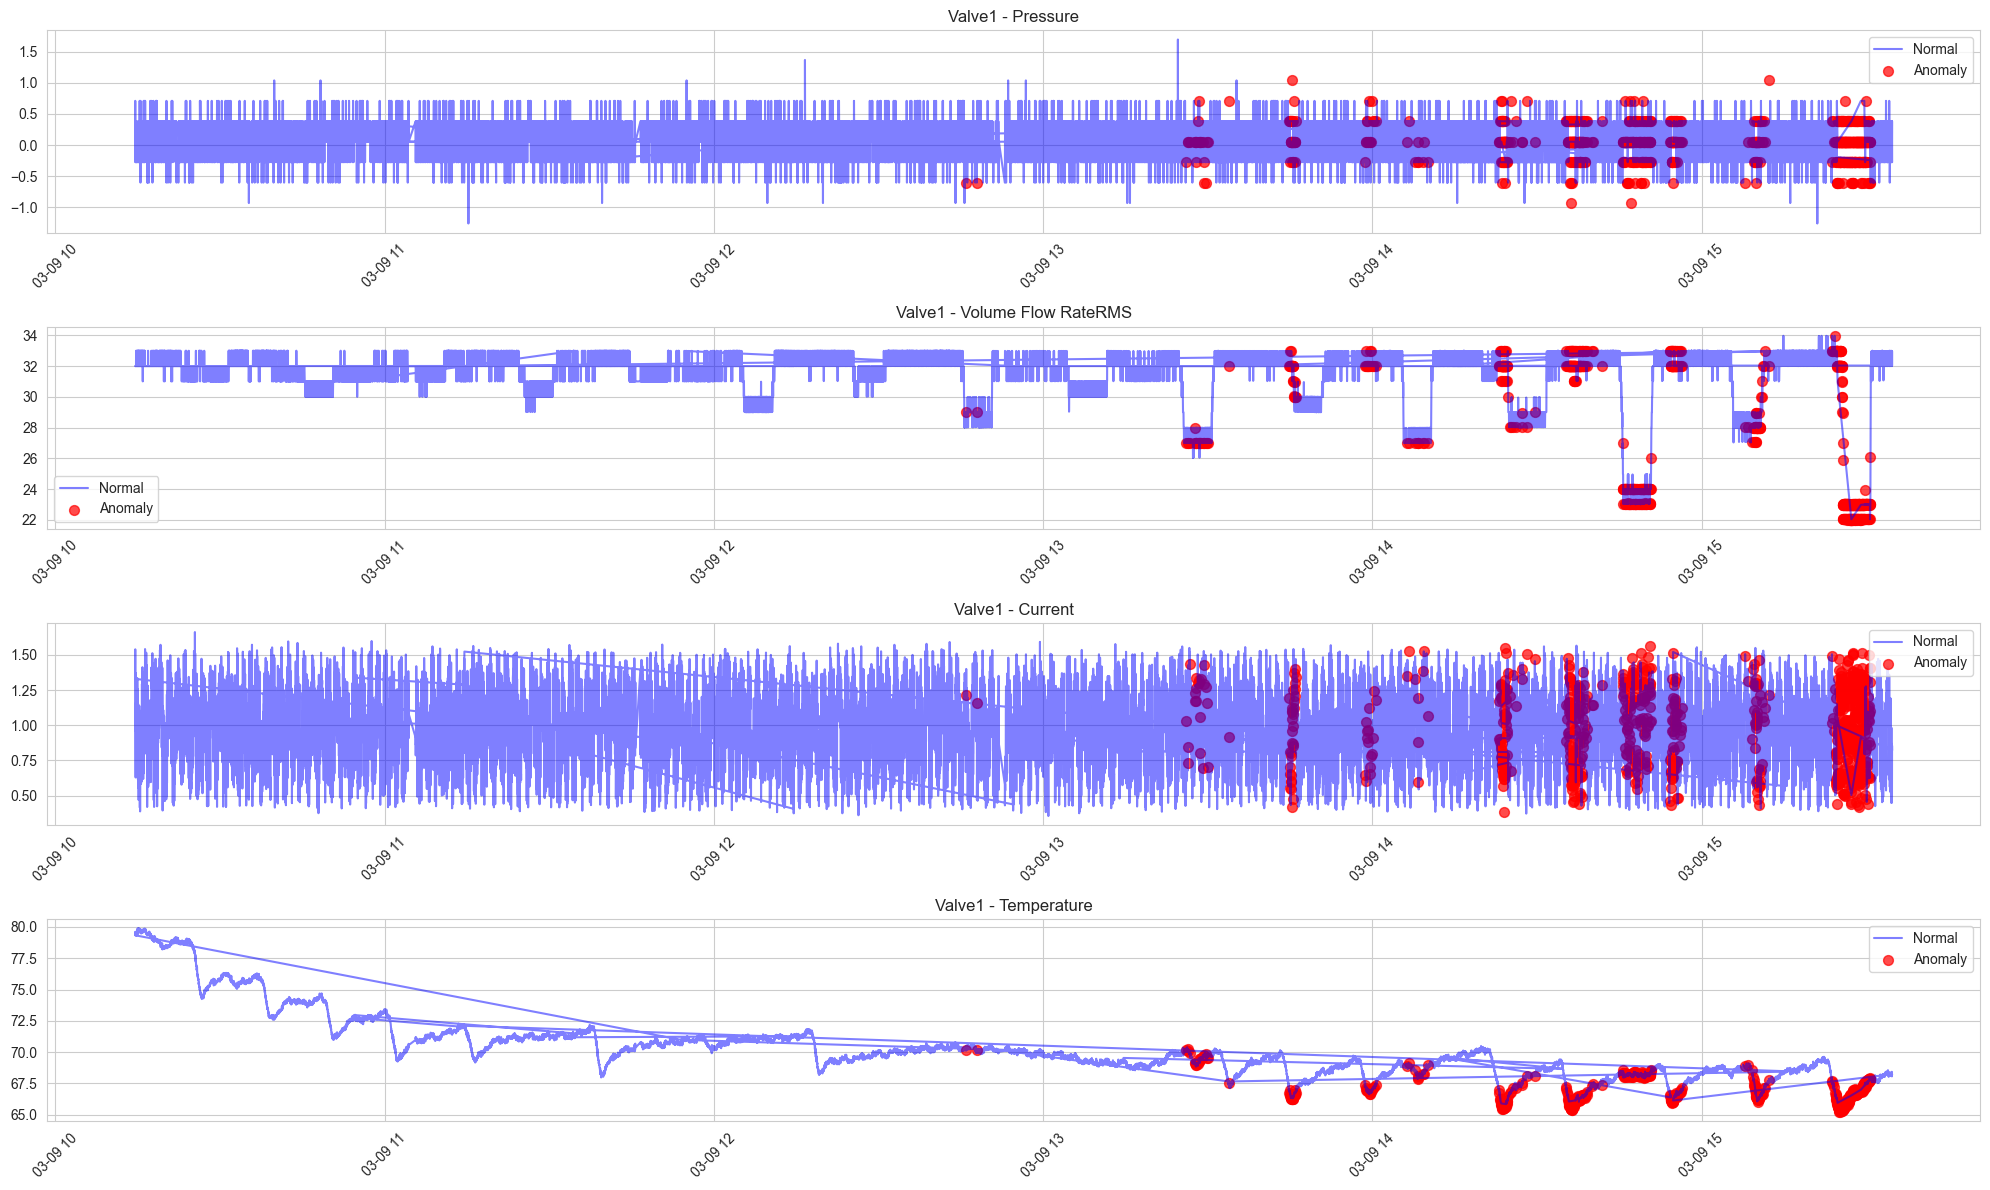

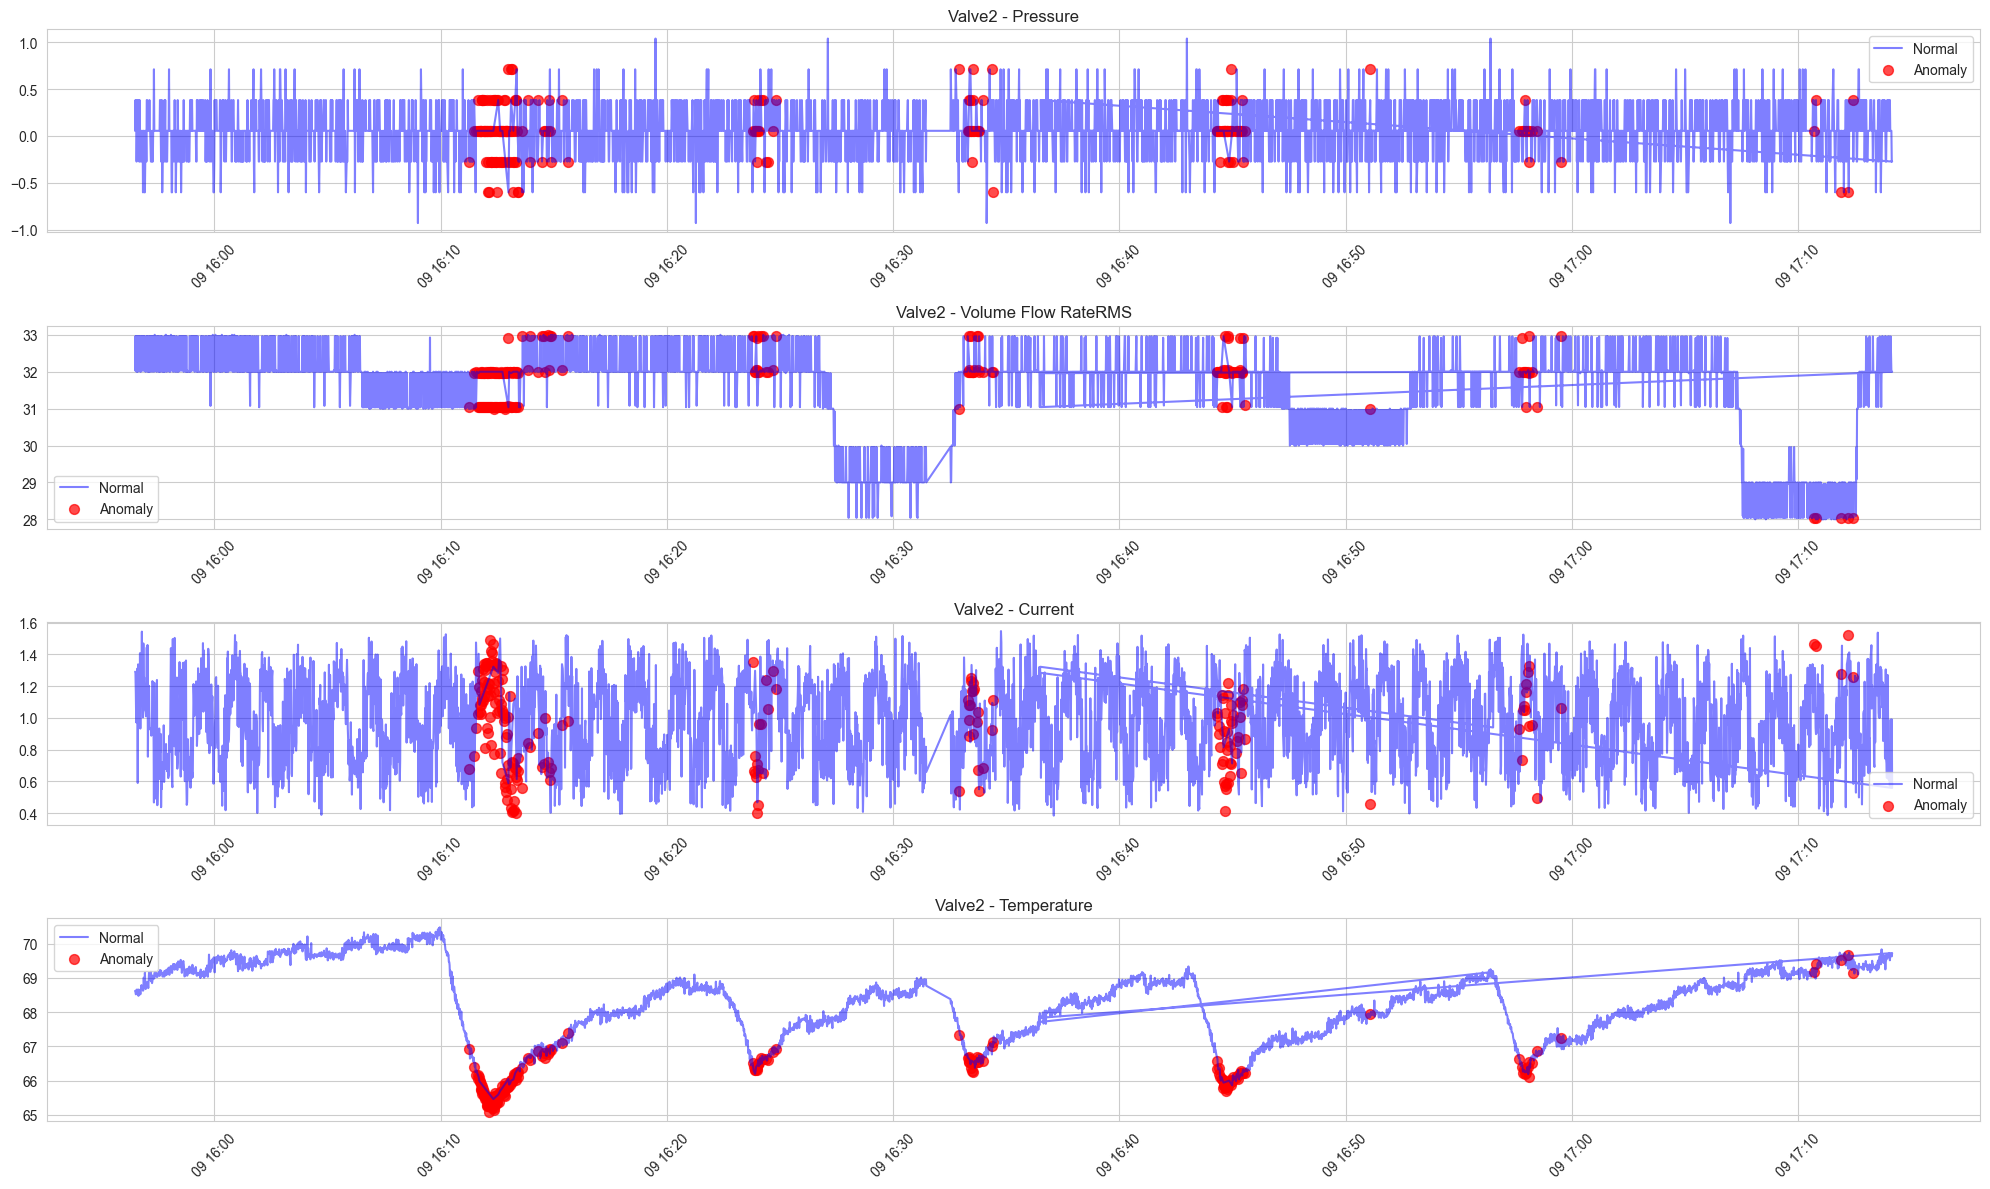

In [ ]:
def plot_anomalies_timeseries(df, predictions, dataset_name):
    metrics = ["Pressure", "Volume Flow RateRMS", "Current", "Temperature"]
    
    plt.figure(figsize=(20, 12))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(len(metrics), 1, i)
        
        normal_mask = predictions == 0
        plt.plot(df['datetime'][normal_mask], 
                df[metric][normal_mask], 
                color='blue', 
                label='Normal', 
                alpha=0.5)
        
        anomaly_mask = predictions == 1
        plt.scatter(df['datetime'][anomaly_mask], 
                   df[metric][anomaly_mask], 
                   color='red', 
                   label='Anomaly', 
                   alpha=0.7,
                   s=50)
        
        plt.title(f'{dataset_name} - {metric}')
        plt.legend()
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_anomalies_timeseries(valve1_df, valve1_predictions, "Valve1")

plot_anomalies_timeseries(valve2_df, valve2_predictions, "Valve2")

In [ ]:
from sklearn.metrics import silhouette_score
from scipy.stats import entropy

def evaluate_unsupervised(data, predictions, scores):
    metrics = {}
    
    # 1. Silhouette Score - measures how similar points are within clusters
    # compared to other clusters
    metrics['silhouette'] = silhouette_score(data, predictions)
    
    # 2. Relative Density Score
    # Compare density of points marked as normal vs anomalous
    normal_density = np.mean(scores[predictions == 0])
    anomaly_density = np.mean(scores[predictions == 1])
    metrics['density_ratio'] = anomaly_density / normal_density
    
    # 3. Distribution Separation Score
    # How well separated are normal and anomaly score distributions
    normal_scores = scores[predictions == 0]
    anomaly_scores = scores[predictions == 1]
    separation = abs(np.mean(normal_scores) - np.mean(anomaly_scores)) / \
                (np.std(normal_scores) + np.std(anomaly_scores))
    metrics['separation'] = separation
    
    metrics['local_density_consistency'] = np.percentile(scores[predictions == 1], 25) > \
                                         np.percentile(scores[predictions == 0], 75)
    
    return metrics

v1_metrics = evaluate_unsupervised(valve1_scaled, valve1_predictions, valve1_scores)
print("\nValve1 Unsupervised Evaluation:")
for metric, value in v1_metrics.items():
    print(f"{metric}: {value:.3f}")

v2_metrics = evaluate_unsupervised(valve2_scaled, valve2_predictions, valve2_scores)
print("\nValve2 Unsupervised Evaluation:")
for metric, value in v2_metrics.items():
    print(f"{metric}: {value:.3f}")


Valve1 Unsupervised Evaluation:
silhouette: 0.274
density_ratio: 1.042
separation: 1.994
local_density_consistency: 1.000

Valve2 Unsupervised Evaluation:
silhouette: 0.255
density_ratio: 1.037
separation: 1.975
local_density_consistency: 1.000


### Isolation Forest

In [ ]:
def detect_anomalies_iforest(anomaly_free_scaled, test_scaled):
    iforest = IsolationForest(
        n_estimators=200,
        contamination=0.005,  
        random_state=42,
        max_samples='auto',
        bootstrap=True, 
        n_jobs=-1  
    )
    
    iforest.fit(anomaly_free_scaled)
    
    predictions = iforest.predict(test_scaled)
    predictions = (predictions == -1).astype(int)
    
    scores = -iforest.score_samples(test_scaled)
    threshold = np.mean(scores) + 2 * np.std(scores)
    predictions = (scores > threshold).astype(int)
    
    return predictions, scores

valve1_predictions, valve1_scores = detect_anomalies_iforest(anomaly_free_scaled, valve1_scaled)
valve2_predictions, valve2_scores = detect_anomalies_iforest(anomaly_free_scaled, valve2_scaled)

print(f"Valve1 anomaly rate: {np.mean(valve1_predictions):.3f}")
print(f"Valve2 anomaly rate: {np.mean(valve2_predictions):.3f}")

precision_v1, recall_v1, f1_v1 = calculate_metrics(valve1_predictions, valve1_scores)
print("\nValve1 Metrics:")
print(f"Precision: {precision_v1:.3f}")
print(f"Recall: {recall_v1:.3f}")
print(f"F1-score: {f1_v1:.3f}")

precision_v2, recall_v2, f1_v2 = calculate_metrics(valve2_predictions, valve2_scores)
print("\nValve2 Metrics:")
print(f"Precision: {precision_v2:.3f}")
print(f"Recall: {recall_v2:.3f}")
print(f"F1-score: {f2_v2:.3f}")

Valve1 anomaly rate: 0.045
Valve2 anomaly rate: 0.045

Valve1 Metrics:
Precision: 1.000
Recall: 0.900
F1-score: 0.947

Valve2 Metrics:
Precision: 1.000
Recall: 0.889
F1-score: 0.000


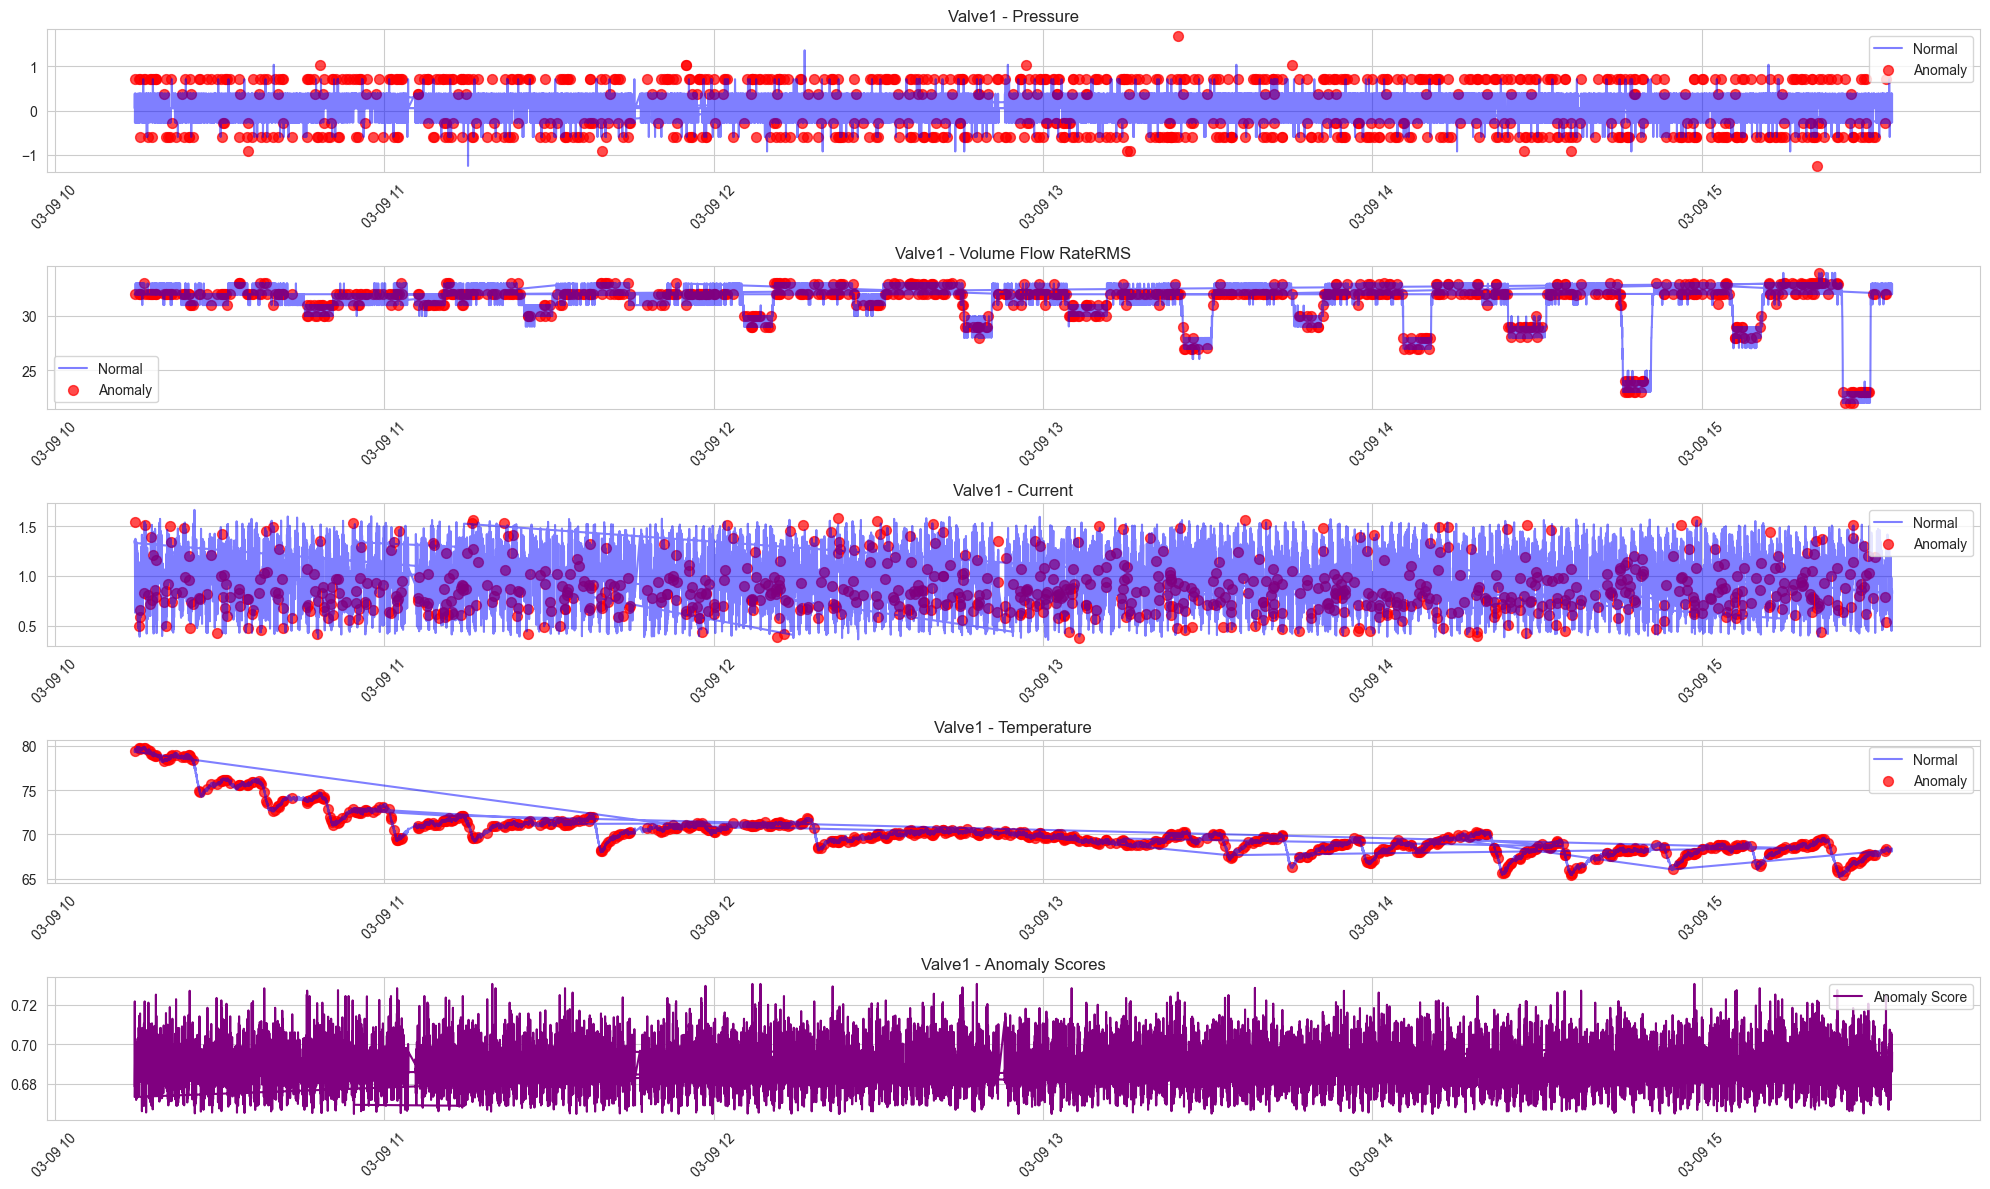

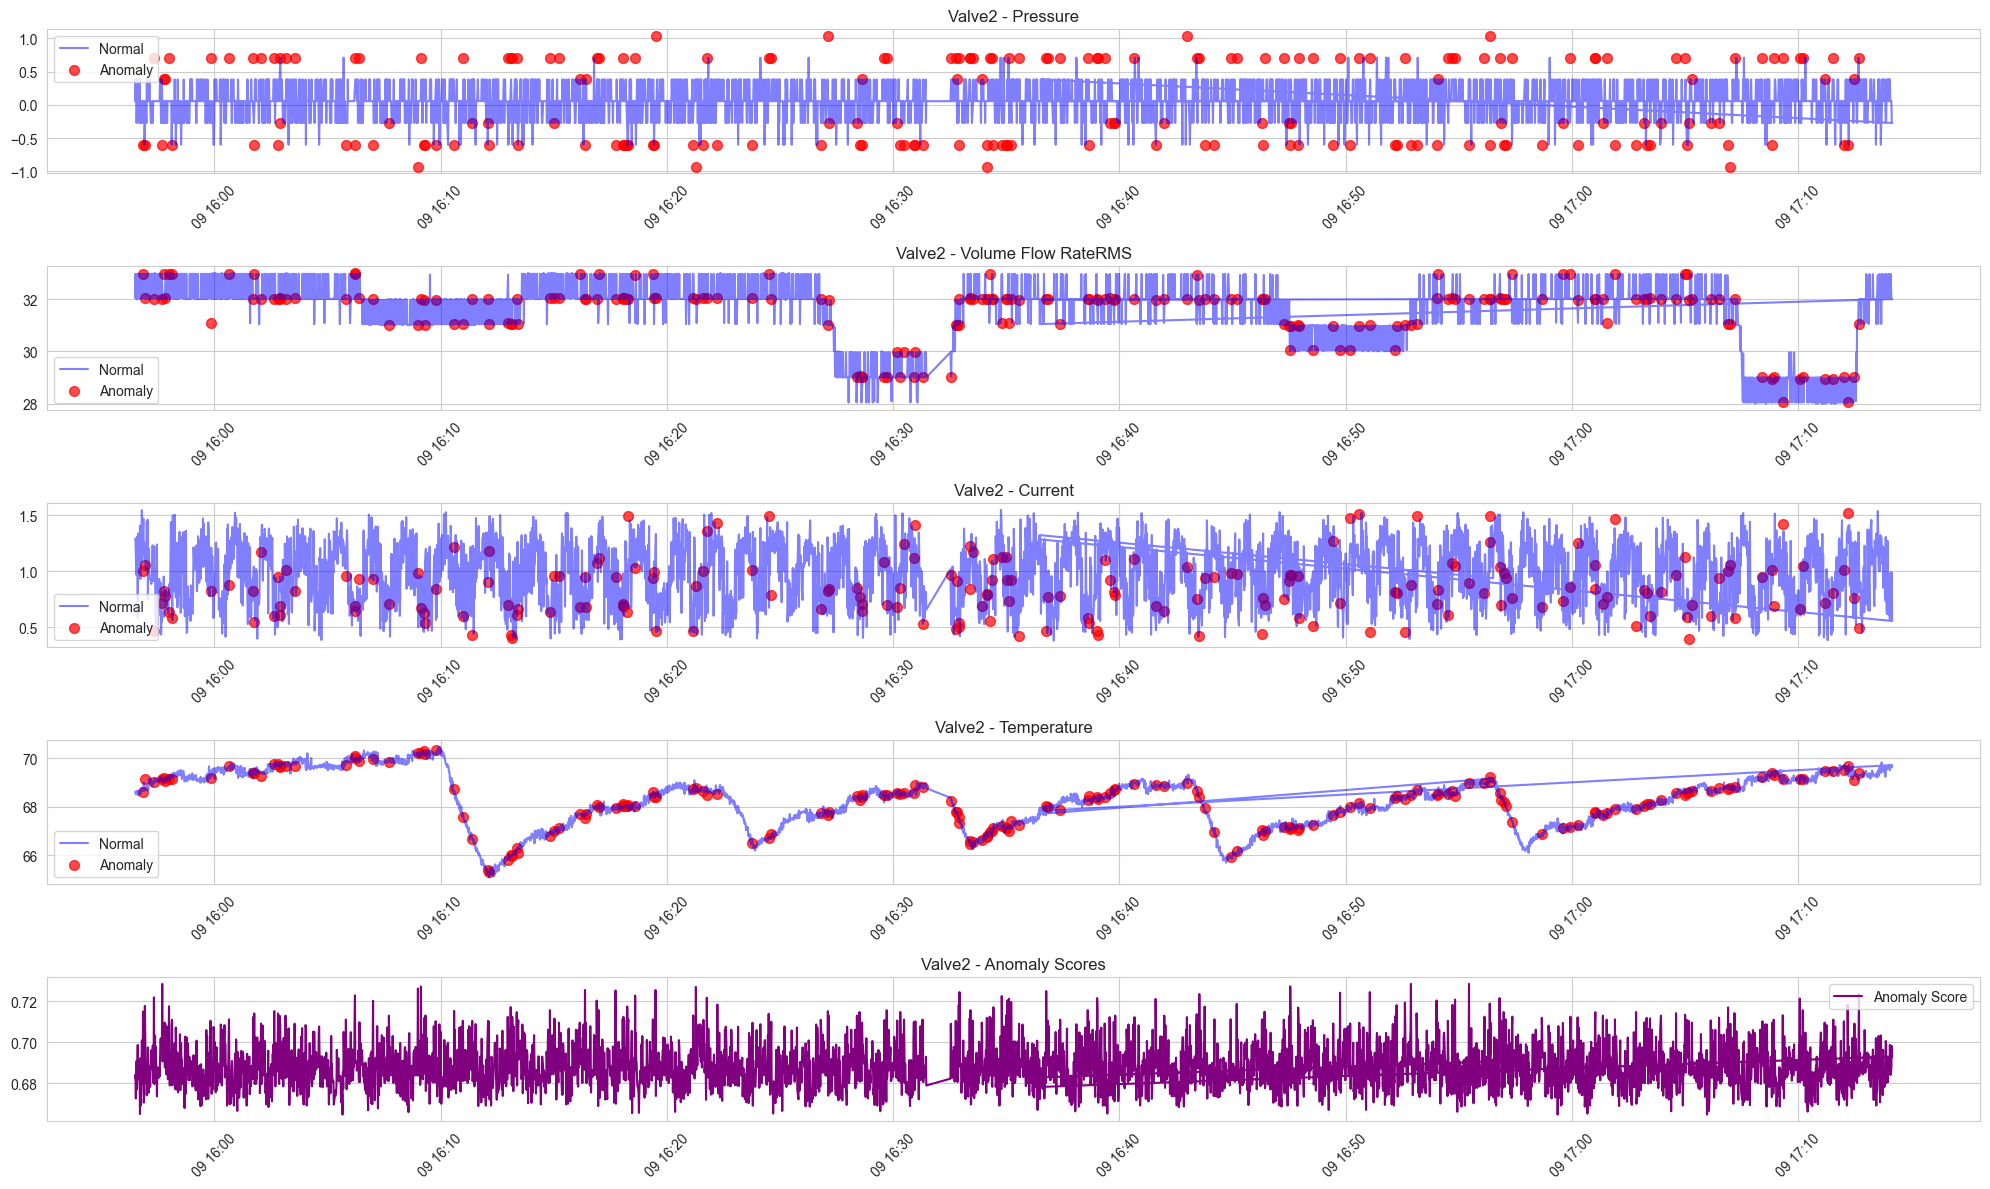


Valve1 Unsupervised Evaluation:
avg_path_length: 0.688
distribution_separation: 1.950
density_ratio: 1.040
temporal_consistency: 0.917

Valve2 Unsupervised Evaluation:
avg_path_length: 0.688
distribution_separation: 1.964
density_ratio: 1.040
temporal_consistency: 0.915


In [ ]:
def plot_anomalies_timeseries(df, predictions, scores, dataset_name):
   metrics = ["Pressure", "Volume Flow RateRMS", "Current", "Temperature"]
   
   plt.figure(figsize=(20, 12))
   
   for i, metric in enumerate(metrics, 1):
       plt.subplot(len(metrics) + 1, 1, i)
       
       normal_mask = predictions == 0
       plt.plot(df['datetime'][normal_mask], 
               df[metric][normal_mask], 
               color='blue', 
               label='Normal', 
               alpha=0.5)
       
       anomaly_mask = predictions == 1
       plt.scatter(df['datetime'][anomaly_mask], 
                  df[metric][anomaly_mask], 
                  color='red', 
                  label='Anomaly', 
                  alpha=0.7,
                  s=50)
       
       plt.title(f'{dataset_name} - {metric}')
       plt.legend()
       plt.xticks(rotation=45)
   
   plt.subplot(len(metrics) + 1, 1, len(metrics) + 1)
   plt.plot(df['datetime'], scores, label='Anomaly Score', color='purple')
   plt.title(f'{dataset_name} - Anomaly Scores')
   plt.legend()
   plt.xticks(rotation=45)
   
   plt.tight_layout()
   plt.show()

plot_anomalies_timeseries(valve1_df, valve1_predictions, valve1_scores, "Valve1")
plot_anomalies_timeseries(valve2_df, valve2_predictions, valve2_scores, "Valve2")

def evaluate_unsupervised(data, predictions, scores):
   metrics = {}
   
   # 1. Average Path Length Score (inherent to Isolation Forest)
   # Higher means more anomalous
   metrics['avg_path_length'] = np.mean(scores)
   
   # 2. Score Distribution
   normal_scores = scores[predictions == 0]
   anomaly_scores = scores[predictions == 1]
   
   if len(anomaly_scores) > 0 and len(normal_scores) > 0:
       # Separation between normal and anomaly distributions
       metrics['distribution_separation'] = abs(np.mean(normal_scores) - np.mean(anomaly_scores)) / \
                                         (np.std(normal_scores) + np.std(anomaly_scores))
   
       # 3. Local Density Ratio
       metrics['density_ratio'] = np.mean(anomaly_scores) / np.mean(normal_scores)
   
   # 4. Temporal consistency score
   # Check if anomalies appear in clusters (more realistic for valve problems)
   temporal_consistency = np.mean([int(a == b) for a, b in zip(predictions[:-1], predictions[1:])])
   metrics['temporal_consistency'] = temporal_consistency
   
   return metrics

v1_metrics = evaluate_unsupervised(valve1_scaled, valve1_predictions, valve1_scores)
print("\nValve1 Unsupervised Evaluation:")
for metric, value in v1_metrics.items():
   print(f"{metric}: {value:.3f}")

v2_metrics = evaluate_unsupervised(valve2_scaled, valve2_predictions, valve2_scores)
print("\nValve2 Unsupervised Evaluation:")
for metric, value in v2_metrics.items():
   print(f"{metric}: {value:.3f}")

## Transformer Autoencoder

In [ ]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=64, nhead=8):
        super().__init__()
        self.d_model = d_model
        self.input_proj = nn.Linear(input_dim, d_model)
        
        self.transformer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )
        
        self.decoder = nn.Linear(d_model, input_dim)
        
    def forward(self, x):
        x = self.input_proj(x)  
        x = self.transformer(x)  
        x = self.decoder(x)   
        return x

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        sequences = []
        for i in range(len(data) - seq_length + 1):
            sequences.append(data[i:i + seq_length])
        self.sequences = torch.FloatTensor(sequences)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx]

def train_model(model, train_loader, optimizer, criterion, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch in progress_bar:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            output = model(batch)
            loss = criterion(output, batch)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': total_loss/len(train_loader)})

def detect_anomalies_transformer(model, data, seq_length, threshold_multiplier=2):
    model.eval()
    dataset = TimeSeriesDataset(data, seq_length)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    reconstruction_errors = []
    with torch.no_grad():
        for batch in tqdm(loader, desc='Detecting anomalies'):
            batch = batch.to(device)
            output = model(batch)
            error = torch.mean((output - batch) ** 2, dim=(1,2))
            reconstruction_errors.extend(error.cpu().numpy())
    
    reconstruction_errors = np.array(reconstruction_errors)
    threshold = np.mean(reconstruction_errors) + threshold_multiplier * np.std(reconstruction_errors)
    predictions = (reconstruction_errors > threshold).astype(int)
    
    full_predictions = np.zeros(len(data))
    for i in range(len(predictions)):
        full_predictions[i:i + seq_length] = predictions[i]
    
    return full_predictions, reconstruction_errors

seq_length = 50
input_dim = anomaly_free_scaled.shape[1]
d_model = 64  
nhead = 8
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

train_dataset = TimeSeriesDataset(anomaly_free_scaled, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = TransformerAutoencoder(input_dim, seq_length, d_model, nhead).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print("Training Transformer Autoencoder...")
train_model(model, train_loader, optimizer, criterion, device, epochs=10)


Using device: cpu
Training Transformer Autoencoder...


Epoch 10/10: 100%|██████████| 293/293 [00:11<00:00, 24.45it/s, loss=0.000206]



Detecting anomalies for Valve1...


Detecting anomalies: 100%|██████████| 566/566 [00:03<00:00, 158.57it/s]


Detecting anomalies for Valve2...


Detecting anomalies: 100%|██████████| 134/134 [00:00<00:00, 153.78it/s]



Valve1 anomaly rate: 0.035
Valve2 anomaly rate: 0.019


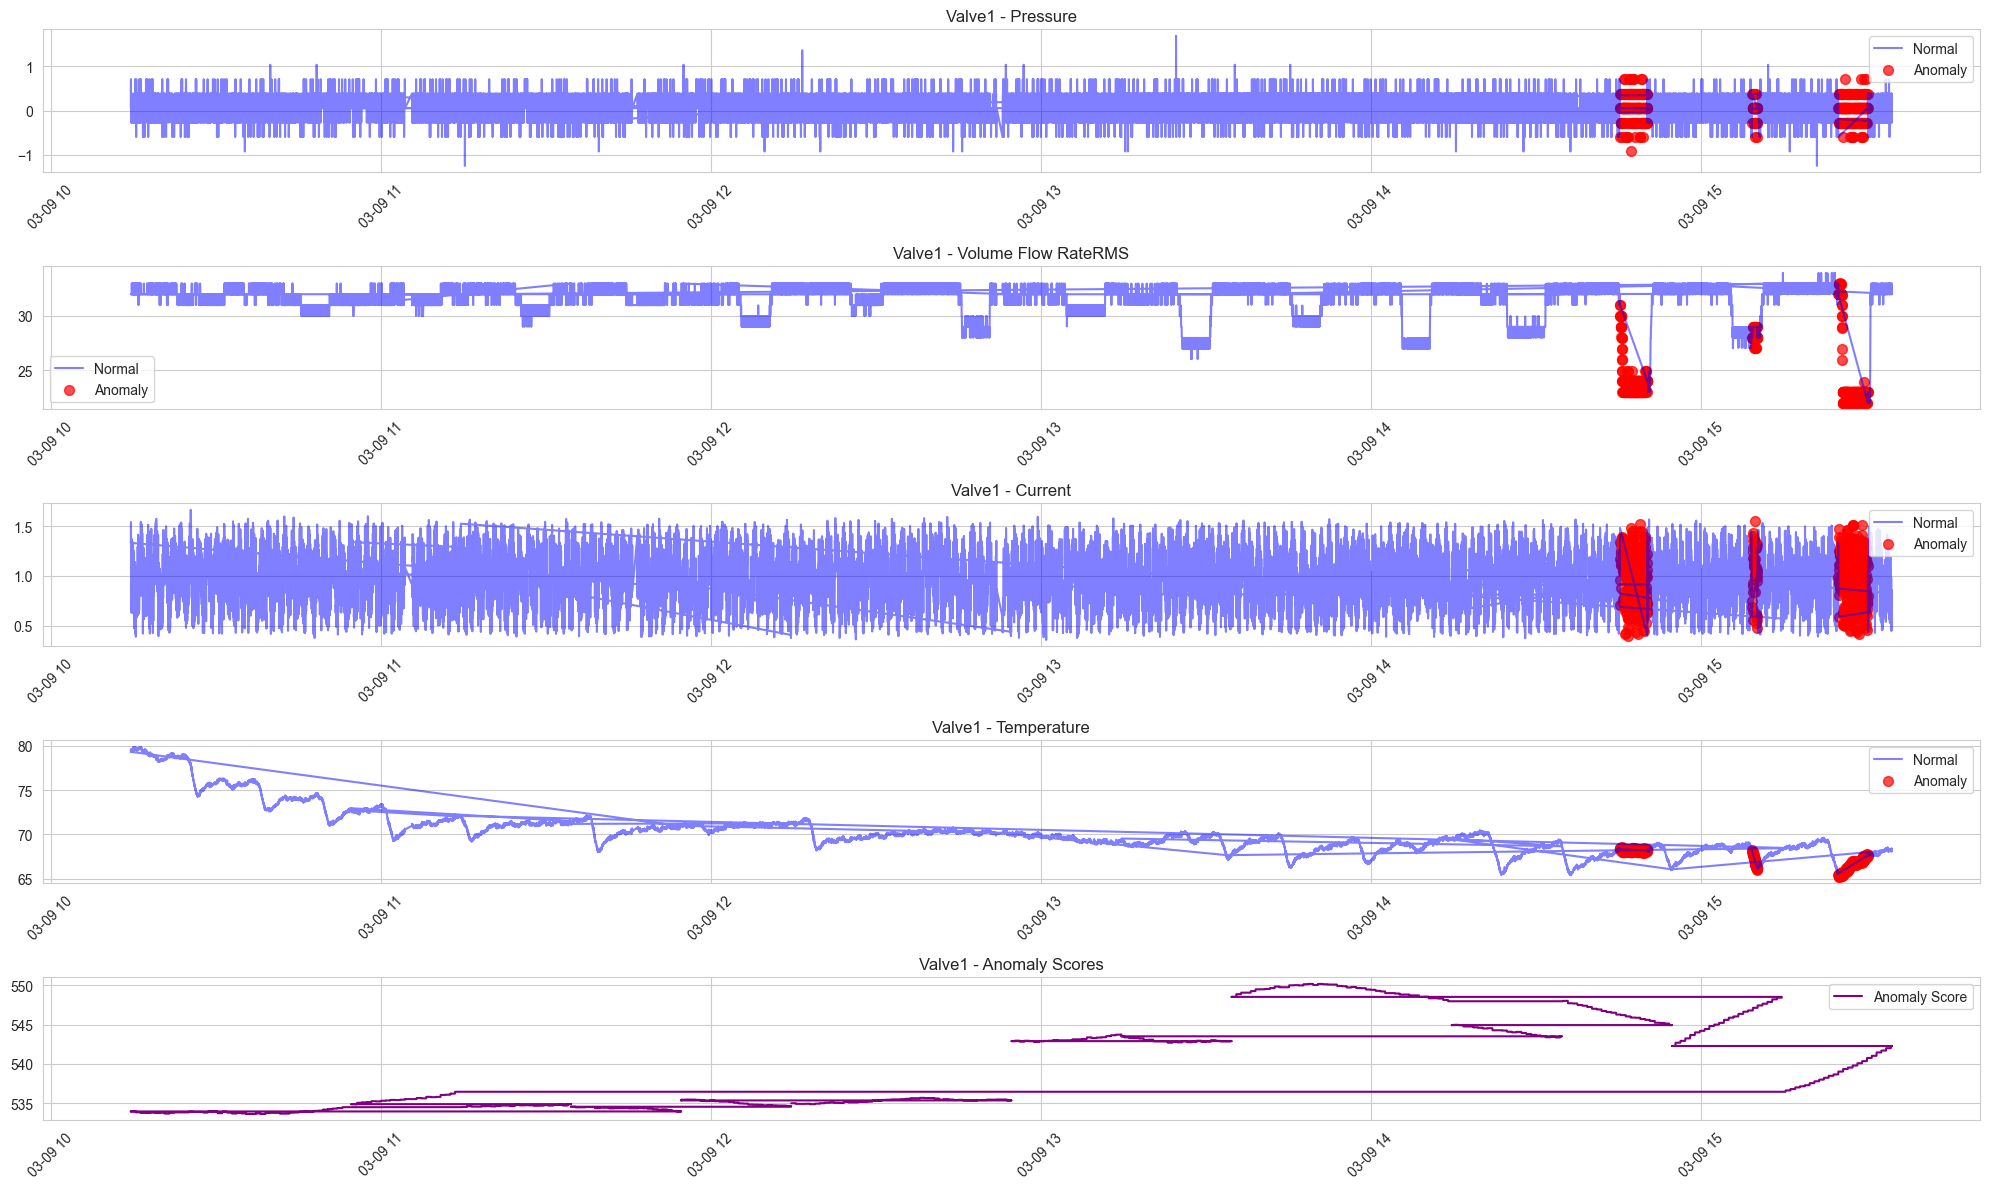

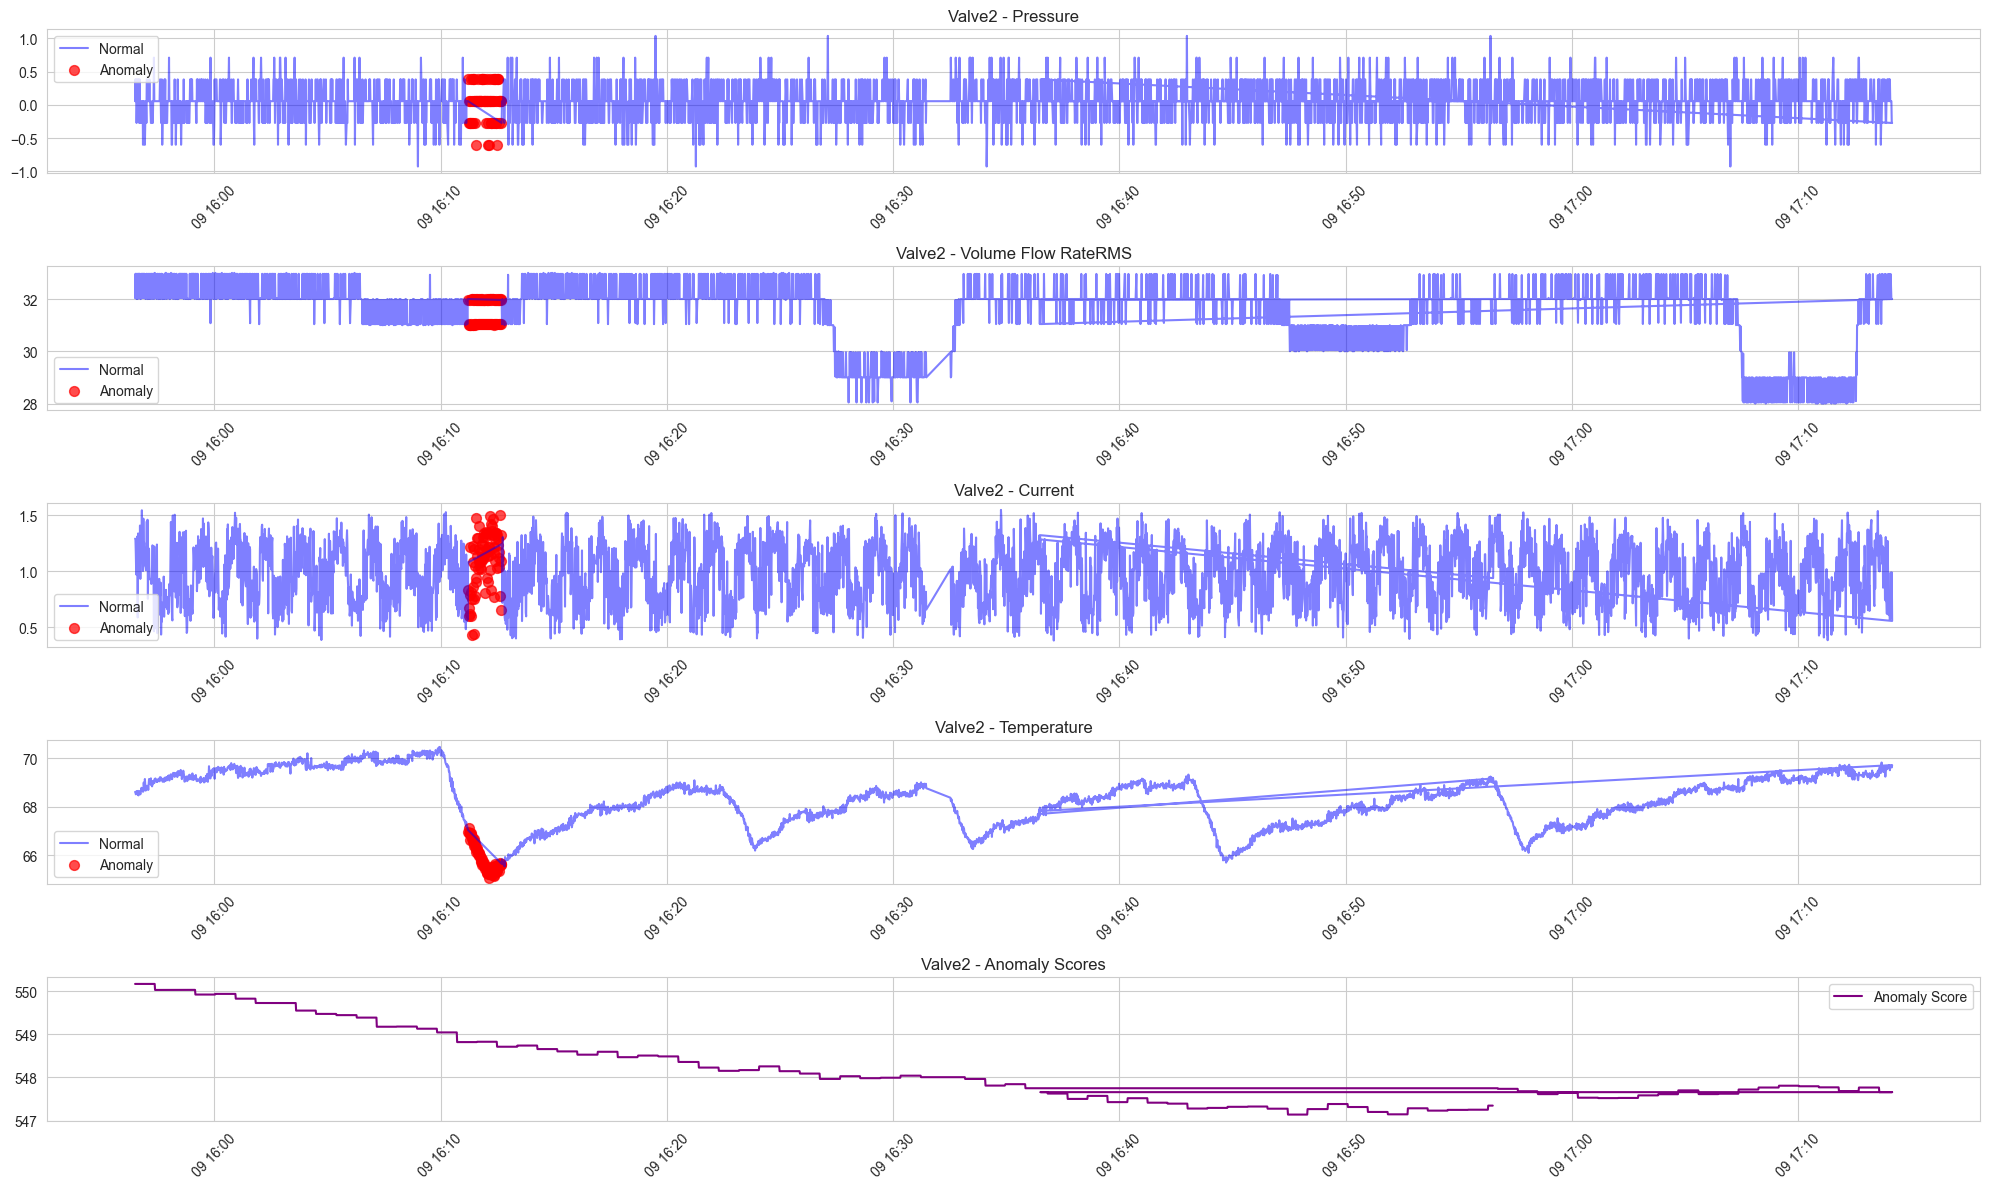

In [85]:
print("\nDetecting anomalies for Valve1...")
valve1_predictions, valve1_scores = detect_anomalies_transformer(model, valve1_scaled, seq_length)

print("Detecting anomalies for Valve2...")
valve2_predictions, valve2_scores = detect_anomalies_transformer(model, valve2_scaled, seq_length)

print(f"\nValve1 anomaly rate: {np.mean(valve1_predictions):.3f}")
print(f"Valve2 anomaly rate: {np.mean(valve2_predictions):.3f}")

plot_anomalies_timeseries(valve1_df, valve1_predictions, valve1_scores, "Valve1")
plot_anomalies_timeseries(valve2_df, valve2_predictions, valve2_scores, "Valve2")


In [ ]:
def evaluate_unsupervised(data, predictions, scores):
    min_len = min(len(predictions), len(scores), len(data))
    predictions = predictions[:min_len]
    scores = scores[:min_len]
    data = data[:min_len]
    
    metrics = {}
    
    metrics['avg_path_length'] = np.mean(scores)
    
    normal_scores = scores[predictions == 0]
    anomaly_scores = scores[predictions == 1]
    
    if len(anomaly_scores) > 0 and len(normal_scores) > 0:
        metrics['distribution_separation'] = abs(np.mean(normal_scores) - np.mean(anomaly_scores)) / \
                                          (np.std(normal_scores) + np.std(anomaly_scores))
    
        metrics['density_ratio'] = np.mean(anomaly_scores) / np.mean(normal_scores)
    
    temporal_consistency = np.mean([int(a == b) for a, b in zip(predictions[:-1], predictions[1:])])
    metrics['temporal_consistency'] = temporal_consistency
    
    return metrics

print(f"\nValve1 anomaly rate: {np.mean(valve1_predictions):.3f}")
print(f"Valve2 anomaly rate: {np.mean(valve2_predictions):.3f}")

v1_metrics = evaluate_unsupervised(valve1_scaled, valve1_predictions, valve1_scores)
v2_metrics = evaluate_unsupervised(valve2_scaled, valve2_predictions, valve2_scores)

print("\nValve1 Unsupervised Evaluation:")
for metric, value in v1_metrics.items():
    print(f"{metric}: {value:.3f}")

print("\nValve2 Unsupervised Evaluation:")
for metric, value in v2_metrics.items():
    print(f"{metric}: {value:.3f}")


Valve1 anomaly rate: 0.035
Valve2 anomaly rate: 0.019

Valve1 Unsupervised Evaluation:
avg_path_length: 545.440
distribution_separation: 2.238
density_ratio: 1.091
temporal_consistency: 1.000

Valve2 Unsupervised Evaluation:
avg_path_length: 555.934
distribution_separation: 2.129
density_ratio: 1.030
temporal_consistency: 1.000


In [87]:
from sklearn.metrics import precision_score, recall_score, f1_score

min_len = min(len(valve1_predictions), len(valve1_df))
valve1_preds_adjusted = valve1_predictions[:min_len]
valve1_df_adjusted = valve1_df[:min_len]

min_len = min(len(valve2_predictions), len(valve2_df))
valve2_preds_adjusted = valve2_predictions[:min_len]
valve2_df_adjusted = valve2_df[:min_len]

def calculate_metrics(predictions, scores):
    threshold = np.percentile(scores, 95)
    assumed_truth = (scores > threshold).astype(int)
    
    min_len = min(len(predictions), len(assumed_truth))
    predictions = predictions[:min_len]
    assumed_truth = assumed_truth[:min_len]
    
    precision = precision_score(assumed_truth, predictions)
    recall = recall_score(assumed_truth, predictions)
    f1 = f1_score(assumed_truth, predictions)
    
    return precision, recall, f1

precision_v1, recall_v1, f1_v1 = calculate_metrics(valve1_predictions, valve1_scores)
print("\nValve1 Supervised Metrics:")
print(f"Precision: {precision_v1:.3f}")
print(f"Recall: {recall_v1:.3f}")
print(f"F1-score: {f1_v1:.3f}")

precision_v2, recall_v2, f1_v2 = calculate_metrics(valve2_predictions, valve2_scores)
print("\nValve2 Supervised Metrics:")
print(f"Precision: {precision_v2:.3f}")
print(f"Recall: {recall_v2:.3f}")
print(f"F1-score: {f2_v2:.3f}")


Valve1 Supervised Metrics:
Precision: 1.000
Recall: 0.704
F1-score: 0.826

Valve2 Supervised Metrics:
Precision: 1.000
Recall: 0.388
F1-score: 0.000
